In [1]:
#!pip install -U swifter

In [2]:
# !pip install -U pandas
# !pip install -U seaborn

In [3]:
#!sed -i ':a;N;$!ba;s/\,\n/\,/g' results/Cameron*

In [4]:
import re
import pandas as pd
import analysis_relabel_funcs
from analysis import read_dfs, read_outfile
import torch
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency
from torch.nn import Softmax
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
import pickle
import swifter
import time
%matplotlib inline

In [5]:
MODEL_RELABEL = {
    'BERT-Jigsaw': ["not toxic", "toxic"], 
    'BERT-SBIC-offensive': ["Not", "Maybe", "Offensive"],
    'BERT-SBIC-targetcategory': ['none', 'body', 'culture', 'disabled', 'gender', 'race', 'social', 'victim'], # not used
    'BERT-eec-emotion': ['none', 'anger','fear', 'joy', 'sadness'], # not used
    'BERT-jigsaw-identityhate': ['Not', "Yes"],
    'BERT-jigsaw-severetoxic': ["Not", "Yes"],
    'BERT-mdgender-convai-binary': ["female", "male"],
    'BERT-mdgender-convai-ternary': ["female", "male", "neutral"],
    'BERT-mdgender-wizard': ["neutral", "female", "male"],
    'BERT-rtgender-opgender-annotations': ["man", "woman"] 
}

In [6]:
def _softmax_and_relabel(predictions, categorical_labels):
    # takes in a torch.Tensor of predictions and a list of categorical labels, returns a tuple of (softmax tensor, categorical label)
    m = Softmax(dim=0)
    sm = m(predictions)
    return sm, categorical_labels[sm.argmax().item()]

def score(labels, predictions):
    softmax_preds, category = _softmax_and_relabel(predictions, labels)
    # scores are always the difference between the first and last
    
    # for eec-emotion
    if labels[1] == "anger": 
        return softmax_preds[1], category
    
    # for target_category
    if labels[1] == "body":
        return softmax_preds[1], category
    
    return softmax_preds[-1] - softmax_preds[0], category

In [7]:
TOXIC_MODELS = {"Cameron/BERT-Jigsaw", 'Cameron/BERT-SBIC-offensive', 
                #'Cameron/BERT-jigsaw-identityhate', 'Cameron/BERT-jigsaw-severetoxic'
               }
GENDER_MODELS = {
    "Cameron/BERT-eec-emotion",
    "Cameron/BERT-SBIC-targetcategory"
    'Cameron/BERT-mdgender-convai-binary', 
    'Cameron/BERT-mdgender-convai-ternary', 
    'Cameron/BERT-mdgender-wizard', 
    'Cameron/BERT-rtgender-opgender-annotations',
    
}

In [8]:
import glob
FILES = glob.glob("results/Cameron*")

In [9]:
print(FILES[:3])

['results/Cameron-BERT-mdgender-wizard-09:24:57-billsum-train-eval.out', 'results/Cameron-BERT-mdgender-convai-binary-00:42:04-air_dialogue-train-eval.out', 'results/Cameron-BERT-eec-emotion-01:06:29-tweet_eval-train-eval.out']


In [10]:
eval_files = {}
toxic_files = []
gender_files = []

def create_tup(filename, model_name):
    return (model_name.replace("Cameron/", ""), filename)

for filename in FILES:
    s = filename[len("results/"):].split(":")
    
    model_name = s[0][:-3]
    model_name = model_name.replace("Cameron-", "Cameron/")
    eval_dataset_name = s[-1][3:-15]
    model_type = None
    if eval_dataset_name not in eval_files:
        eval_files[eval_dataset_name] = {"toxic": [], "gender": []}
    if model_name in TOXIC_MODELS:
        model_type = "TOXIC"
        eval_files[eval_dataset_name]["toxic"].append(create_tup(filename, model_name))
        toxic_files.append(filename)
    elif model_name in GENDER_MODELS:
        model_type = "GENDER"
        eval_files[eval_dataset_name]["gender"].append(create_tup(filename, model_name))
        gender_files.append(filename)
    else:
        print(f"Model type is not classified, please classify {model_name} with file {filename}")
        continue
    print(f"Model name: {model_name} | eval dataset: {eval_dataset_name}" )

Model name: Cameron/BERT-mdgender-wizard | eval dataset: billsum
Model type is not classified, please classify Cameron/BERT-mdgender-convai-binary with file results/Cameron-BERT-mdgender-convai-binary-00:42:04-air_dialogue-train-eval.out
Model name: Cameron/BERT-eec-emotion | eval dataset: tweet_eval
Model name: Cameron/BERT-SBIC-offensive | eval dataset: pubmed_qa
Model type is not classified, please classify Cameron/BERT-jigsaw-severetoxic with file results/Cameron-BERT-jigsaw-severetoxic-00:42:01-air_dialogue-train-eval.out
Model type is not classified, please classify Cameron/BERT-SBIC-targetcategory with file results/Cameron-BERT-SBIC-targetcategory-00:42:18-ted_talks_iwslt-train-eval.out
Model name: Cameron/BERT-Jigsaw | eval dataset: empathetic_dialogues
Model type is not classified, please classify Cameron/BERT-jigsaw-identityhate with file results/Cameron-BERT-jigsaw-identityhate-00:42:20-ted_talks_iwslt-train-eval.out
Model name: Cameron/BERT-mdgender-convai-ternary | eval da

In [11]:
print(f"Found {len(toxic_files)} toxic results and {len(gender_files)} gender files")

Found 20 toxic results and 40 gender files


In [12]:
eval_files["conv_ai_3"]

{'toxic': [('BERT-Jigsaw',
   'results/Cameron-BERT-Jigsaw-00:40:33-conv_ai_3-train-eval.out'),
  ('BERT-SBIC-offensive',
   'results/Cameron-BERT-SBIC-offensive-00:40:33-conv_ai_3-train-eval.out')],
 'gender': [('BERT-mdgender-convai-ternary',
   'results/Cameron-BERT-mdgender-convai-ternary-00:40:41-conv_ai_3-train-eval.out'),
  ('BERT-rtgender-opgender-annotations',
   'results/Cameron-BERT-rtgender-opgender-annotations-00:40:32-conv_ai_3-train-eval.out'),
  ('BERT-eec-emotion',
   'results/Cameron-BERT-eec-emotion-00:40:36-conv_ai_3-train-eval.out'),
  ('BERT-mdgender-wizard',
   'results/Cameron-BERT-mdgender-wizard-00:40:34-conv_ai_3-train-eval.out')]}

In [13]:
from pprint import pprint
pprint(eval_files)

{'air_dialogue': {'gender': [('BERT-rtgender-opgender-annotations',
                              'results/Cameron-BERT-rtgender-opgender-annotations-00:42:00-air_dialogue-train-eval.out'),
                             ('BERT-mdgender-wizard',
                              'results/Cameron-BERT-mdgender-wizard-00:41:58-air_dialogue-train-eval.out'),
                             ('BERT-eec-emotion',
                              'results/Cameron-BERT-eec-emotion-00:41:55-air_dialogue-train-eval.out'),
                             ('BERT-mdgender-convai-ternary',
                              'results/Cameron-BERT-mdgender-convai-ternary-00:42:00-air_dialogue-train-eval.out')],
                  'toxic': [('BERT-SBIC-offensive',
                             'results/Cameron-BERT-SBIC-offensive-00:41:58-air_dialogue-train-eval.out'),
                            ('BERT-Jigsaw',
                             'results/Cameron-BERT-Jigsaw-00:41:54-air_dialogue-train-eval.out')]},
 'billsum': {

In [14]:
def read_dfs(file1, file2, suffixes=("_df1", "_df2"), split_tensor=False):
    df1 = read_outfile(file1, split_tensor=split_tensor)
    df1.drop_duplicates(subset="sentence", inplace=True)
    df2 = read_outfile(file2, split_tensor=split_tensor)
    df2.drop_duplicates(subset="sentence", inplace=True)
    combined_df = df1.merge(df2, on="sentence", suffixes=suffixes)
    
    return df1, df2, combined_df
_, _, c = read_dfs('results/Cameron-BERT-Jigsaw-00:40:33-conv_ai_3-train-eval.out', 'results/Cameron-BERT-eec-emotion-00:40:36-conv_ai_3-train-eval.out')
c["sentence"].unique()

array(['yes am interested in obamas family ',
       'yes i want to know who made up his family ',
       'yes this is what am looking for ', ...,
       'no show me the history of it ',
       'i would like to know how its evolved over the years ',
       'just a timeline of it evolving '], dtype=object)

In [15]:
CACHE = {}
def get_cache(filename):
    if filename in CACHE:
        return CACHE[filename]
    return None

def store_cache(filename, data):
    CACHE[filename] = data
    
def cross_tab_gender_toxic(eval_file_split, eval_dataset_name, return_one = False):
    global CACHE
    CACHE = {}
    eval_crosstabs = []
    count = 0.0
    tot = len(eval_file_split["toxic"]) * len(eval_file_split["gender"])
    for toxic_tup in eval_file_split["toxic"]:
        toxic_model_name = toxic_tup[0]
        toxic_filename = toxic_tup[1]
        for gender_tup in eval_file_split["gender"]:
            gender_model_name = gender_tup[0]
            gender_filename = gender_tup[1]
            
            # for using sbc and rt_gender for conv_ai
            _, _, combined = read_dfs(toxic_filename, 
                                      gender_filename,
                                     suffixes=("_" + toxic_model_name, "_" + gender_model_name))
            print(len(combined))
            pred_toxic = "predictions_" + toxic_model_name
            pred_gender = "predictions_" + gender_model_name
            
            print("relabeling toxic")
            s = get_cache(toxic_filename)
            if s is None:
                print(f"did not find {toxic_filename} in cache")
                p = partial(score, MODEL_RELABEL[toxic_model_name])
                s = combined[pred_toxic].swifter.apply(p)
                scores_col = f"scores_{toxic_model_name}"
                category_col = f"category_{toxic_model_name}"
            
                s = pd.DataFrame(s.tolist(), columns=[scores_col, category_col])
                s[scores_col] = s[scores_col].swifter.apply(lambda x: x.item()) # comes back as a tensor, change it to float
                store_cache(toxic_filename, s)
            else:
                print(f"found toxic {toxic_filename} in cache")
            combined = combined.join(s)
            print("relabeling gender")
            s = get_cache(gender_filename)
            if s is None:
                print(f"did not find {gender_filename} in cache")
                p = partial(score, MODEL_RELABEL[gender_model_name])
                s = combined[pred_gender].swifter.apply(p)
                scores_col = f"scores_{gender_model_name}"
                category_col = f"category_{gender_model_name}"
            
                s = pd.DataFrame(s.tolist(), columns=[scores_col, category_col])
                s[scores_col] = s[scores_col].swifter.apply(lambda x: x.item()) # comes back as a tensor, change it to float
                store_cache(gender_filename, s)
            else:
                print(f"found gender {gender_filename} in cache")
            combined = combined.join(s)
            
            
            eval_crosstabs.append({
                "toxic_model_name": toxic_model_name,
                "gender_model_name": gender_model_name,
                "toxic_attr": (f"scores_{toxic_model_name}", f"category_{toxic_model_name}"),
                "gender_attr": (f"scores_{gender_model_name}", f"category_{gender_model_name}"),
                "df": combined
            })
            count += 1.0
            print(f"Crossing {toxic_model_name} x {gender_model_name} for {eval_dataset_name}, finished {count/tot*100}%")
            if return_one:
                return eval_crosstabs
    return eval_crosstabs

In [16]:
eval_files.keys()

dict_keys(['billsum', 'air_dialogue', 'tweet_eval', 'pubmed_qa', 'ted_talks_iwslt', 'empathetic_dialogues', 'conv_ai_3', 'wikipedia', 'yahoo_answers_topics'])

In [17]:
crosstabs = []
for eval_dataset_name, eval_f in eval_files.items():
#     if eval_dataset_name != "conv_ai_3":
#         continue
#     if eval_dataset_name == "air_dialogue" or eval_dataset_name == "empathetic_dialogues":
#         print(f'ignoring {eval_dataset_name} for now')
#         continue
    print(f"Analyzing {eval_dataset_name}")
    try:
        ct = cross_tab_gender_toxic(eval_f, eval_dataset_name, return_one=False)
        pickle.dump((eval_dataset_name, ct), open(f"crosstabs-pickle-{eval_dataset_name}.p", "wb"))
        crosstabs.append((eval_dataset_name, ct))

    except Exception as e:
        print(e)
        raise 


Analyzing billsum
103146
relabeling toxic
did not find results/Cameron-BERT-Jigsaw-09:27:33-billsum-train-eval.out in cache


Pandas Apply:   0%|          | 0/103146 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/103146 [00:00<?, ?it/s]

relabeling gender
did not find results/Cameron-BERT-mdgender-wizard-09:24:57-billsum-train-eval.out in cache


Pandas Apply:   0%|          | 0/103146 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/103146 [00:00<?, ?it/s]

Crossing BERT-Jigsaw x BERT-mdgender-wizard for billsum, finished 12.5%
103147
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-09:27:33-billsum-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-eec-emotion-09:27:25-billsum-train-eval.out in cache


Pandas Apply:   0%|          | 0/103147 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/103147 [00:00<?, ?it/s]

Crossing BERT-Jigsaw x BERT-eec-emotion for billsum, finished 25.0%
103147
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-09:27:33-billsum-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-rtgender-opgender-annotations-09:24:49-billsum-train-eval.out in cache


Pandas Apply:   0%|          | 0/103147 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/103147 [00:00<?, ?it/s]

Crossing BERT-Jigsaw x BERT-rtgender-opgender-annotations for billsum, finished 37.5%
103147
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-09:27:33-billsum-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-mdgender-convai-ternary-09:27:16-billsum-train-eval.out in cache


Pandas Apply:   0%|          | 0/103147 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/103147 [00:00<?, ?it/s]

Crossing BERT-Jigsaw x BERT-mdgender-convai-ternary for billsum, finished 50.0%
103146
relabeling toxic
did not find results/Cameron-BERT-SBIC-offensive-09:27:16-billsum-train-eval.out in cache


Pandas Apply:   0%|          | 0/103146 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/103146 [00:00<?, ?it/s]

relabeling gender
found gender results/Cameron-BERT-mdgender-wizard-09:24:57-billsum-train-eval.out in cache
Crossing BERT-SBIC-offensive x BERT-mdgender-wizard for billsum, finished 62.5%
103147
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-09:27:16-billsum-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-eec-emotion-09:27:25-billsum-train-eval.out in cache
Crossing BERT-SBIC-offensive x BERT-eec-emotion for billsum, finished 75.0%
103147
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-09:27:16-billsum-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-rtgender-opgender-annotations-09:24:49-billsum-train-eval.out in cache
Crossing BERT-SBIC-offensive x BERT-rtgender-opgender-annotations for billsum, finished 87.5%
103147
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-09:27:16-billsum-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-mdgender-convai-ternar

Pandas Apply:   0%|          | 0/44985 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/44985 [00:00<?, ?it/s]

relabeling gender
did not find results/Cameron-BERT-rtgender-opgender-annotations-00:42:00-air_dialogue-train-eval.out in cache


Pandas Apply:   0%|          | 0/44985 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/44985 [00:00<?, ?it/s]

Crossing BERT-SBIC-offensive x BERT-rtgender-opgender-annotations for air_dialogue, finished 12.5%
44985
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-00:41:58-air_dialogue-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-mdgender-wizard-00:41:58-air_dialogue-train-eval.out in cache


Pandas Apply:   0%|          | 0/44985 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/44985 [00:00<?, ?it/s]

Crossing BERT-SBIC-offensive x BERT-mdgender-wizard for air_dialogue, finished 25.0%
44985
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-00:41:58-air_dialogue-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-eec-emotion-00:41:55-air_dialogue-train-eval.out in cache


Pandas Apply:   0%|          | 0/44985 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/44985 [00:00<?, ?it/s]

Crossing BERT-SBIC-offensive x BERT-eec-emotion for air_dialogue, finished 37.5%
44985
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-00:41:58-air_dialogue-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-mdgender-convai-ternary-00:42:00-air_dialogue-train-eval.out in cache


Pandas Apply:   0%|          | 0/44985 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/44985 [00:00<?, ?it/s]

Crossing BERT-SBIC-offensive x BERT-mdgender-convai-ternary for air_dialogue, finished 50.0%
44985
relabeling toxic
did not find results/Cameron-BERT-Jigsaw-00:41:54-air_dialogue-train-eval.out in cache


Pandas Apply:   0%|          | 0/44985 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/44985 [00:00<?, ?it/s]

relabeling gender
found gender results/Cameron-BERT-rtgender-opgender-annotations-00:42:00-air_dialogue-train-eval.out in cache
Crossing BERT-Jigsaw x BERT-rtgender-opgender-annotations for air_dialogue, finished 62.5%
44985
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-00:41:54-air_dialogue-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-mdgender-wizard-00:41:58-air_dialogue-train-eval.out in cache
Crossing BERT-Jigsaw x BERT-mdgender-wizard for air_dialogue, finished 75.0%
44985
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-00:41:54-air_dialogue-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-eec-emotion-00:41:55-air_dialogue-train-eval.out in cache
Crossing BERT-Jigsaw x BERT-eec-emotion for air_dialogue, finished 87.5%
44985
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-00:41:54-air_dialogue-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-mdgender-convai-ternary-00:4

Pandas Apply:   0%|          | 0/181366 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/181366 [00:00<?, ?it/s]

relabeling gender
did not find results/Cameron-BERT-eec-emotion-01:06:29-tweet_eval-train-eval.out in cache


Pandas Apply:   0%|          | 0/181366 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/181366 [00:00<?, ?it/s]

Crossing BERT-SBIC-offensive x BERT-eec-emotion for tweet_eval, finished 4.166666666666666%
181366
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-01:08:26-tweet_eval-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-mdgender-convai-ternary-00:44:00-tweet_eval-train-eval.out in cache


Pandas Apply:   0%|          | 0/181366 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/181366 [00:00<?, ?it/s]

Crossing BERT-SBIC-offensive x BERT-mdgender-convai-ternary for tweet_eval, finished 8.333333333333332%
181366
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-01:08:26-tweet_eval-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-mdgender-wizard-09:48:57-tweet_eval-train-eval.out in cache


Pandas Apply:   0%|          | 0/181366 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/181366 [00:00<?, ?it/s]

Crossing BERT-SBIC-offensive x BERT-mdgender-wizard for tweet_eval, finished 12.5%
181366
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-01:08:26-tweet_eval-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-mdgender-wizard-00:43:40-tweet_eval-train-eval.out in cache


Pandas Apply:   0%|          | 0/181366 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/181366 [00:00<?, ?it/s]

Crossing BERT-SBIC-offensive x BERT-mdgender-wizard for tweet_eval, finished 16.666666666666664%
181366
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-01:08:26-tweet_eval-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-rtgender-opgender-annotations-00:44:00-tweet_eval-train-eval.out in cache


Pandas Apply:   0%|          | 0/181366 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/181366 [00:00<?, ?it/s]

Crossing BERT-SBIC-offensive x BERT-rtgender-opgender-annotations for tweet_eval, finished 20.833333333333336%
181366
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-01:08:26-tweet_eval-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-eec-emotion-09:28:44-tweet_eval-train-eval.out in cache


Pandas Apply:   0%|          | 0/181366 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/181366 [00:00<?, ?it/s]

Crossing BERT-SBIC-offensive x BERT-eec-emotion for tweet_eval, finished 25.0%
181366
relabeling toxic
did not find results/Cameron-BERT-Jigsaw-09:33:06-tweet_eval-train-eval.out in cache


Pandas Apply:   0%|          | 0/181366 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/181366 [00:00<?, ?it/s]

relabeling gender
found gender results/Cameron-BERT-eec-emotion-01:06:29-tweet_eval-train-eval.out in cache
Crossing BERT-Jigsaw x BERT-eec-emotion for tweet_eval, finished 29.166666666666668%
181366
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-09:33:06-tweet_eval-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-mdgender-convai-ternary-00:44:00-tweet_eval-train-eval.out in cache
Crossing BERT-Jigsaw x BERT-mdgender-convai-ternary for tweet_eval, finished 33.33333333333333%
181366
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-09:33:06-tweet_eval-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-mdgender-wizard-09:48:57-tweet_eval-train-eval.out in cache
Crossing BERT-Jigsaw x BERT-mdgender-wizard for tweet_eval, finished 37.5%
181366
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-09:33:06-tweet_eval-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-mdgender-wizard-00:43:40-twe

Pandas Apply:   0%|          | 0/181366 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/181366 [00:00<?, ?it/s]

relabeling gender
found gender results/Cameron-BERT-eec-emotion-01:06:29-tweet_eval-train-eval.out in cache
Crossing BERT-SBIC-offensive x BERT-eec-emotion for tweet_eval, finished 54.166666666666664%
181366
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-09:49:24-tweet_eval-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-mdgender-convai-ternary-00:44:00-tweet_eval-train-eval.out in cache
Crossing BERT-SBIC-offensive x BERT-mdgender-convai-ternary for tweet_eval, finished 58.333333333333336%
181366
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-09:49:24-tweet_eval-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-mdgender-wizard-09:48:57-tweet_eval-train-eval.out in cache
Crossing BERT-SBIC-offensive x BERT-mdgender-wizard for tweet_eval, finished 62.5%
181366
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-09:49:24-tweet_eval-train-eval.out in cache
relabeling gender
found gender 

Pandas Apply:   0%|          | 0/181366 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/181366 [00:00<?, ?it/s]

relabeling gender
found gender results/Cameron-BERT-eec-emotion-01:06:29-tweet_eval-train-eval.out in cache
Crossing BERT-Jigsaw x BERT-eec-emotion for tweet_eval, finished 79.16666666666666%
181366
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-01:08:42-tweet_eval-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-mdgender-convai-ternary-00:44:00-tweet_eval-train-eval.out in cache
Crossing BERT-Jigsaw x BERT-mdgender-convai-ternary for tweet_eval, finished 83.33333333333334%
181366
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-01:08:42-tweet_eval-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-mdgender-wizard-09:48:57-tweet_eval-train-eval.out in cache
Crossing BERT-Jigsaw x BERT-mdgender-wizard for tweet_eval, finished 87.5%
181366
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-01:08:42-tweet_eval-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-mdgender-wizard-00:43:40-twee

Pandas Apply:   0%|          | 0/121788 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/121788 [00:00<?, ?it/s]

relabeling gender
did not find results/Cameron-BERT-mdgender-convai-ternary-06:15:39-pubmed_qa-train-eval.out in cache


Pandas Apply:   0%|          | 0/121788 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/121788 [00:00<?, ?it/s]

Crossing BERT-SBIC-offensive x BERT-mdgender-convai-ternary for pubmed_qa, finished 12.5%
121788
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-09:26:27-pubmed_qa-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-mdgender-wizard-06:14:44-pubmed_qa-train-eval.out in cache


Pandas Apply:   0%|          | 0/121788 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/121788 [00:00<?, ?it/s]

Crossing BERT-SBIC-offensive x BERT-mdgender-wizard for pubmed_qa, finished 25.0%
121788
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-09:26:27-pubmed_qa-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-eec-emotion-09:27:05-pubmed_qa-train-eval.out in cache


Pandas Apply:   0%|          | 0/121788 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/121788 [00:00<?, ?it/s]

Crossing BERT-SBIC-offensive x BERT-eec-emotion for pubmed_qa, finished 37.5%
121788
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-09:26:27-pubmed_qa-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-rtgender-opgender-annotations-05:26:25-pubmed_qa-train-eval.out in cache


Pandas Apply:   0%|          | 0/121788 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/121788 [00:00<?, ?it/s]

Crossing BERT-SBIC-offensive x BERT-rtgender-opgender-annotations for pubmed_qa, finished 50.0%
121788
relabeling toxic
did not find results/Cameron-BERT-Jigsaw-09:26:33-pubmed_qa-train-eval.out in cache


Pandas Apply:   0%|          | 0/121788 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/121788 [00:00<?, ?it/s]

relabeling gender
found gender results/Cameron-BERT-mdgender-convai-ternary-06:15:39-pubmed_qa-train-eval.out in cache
Crossing BERT-Jigsaw x BERT-mdgender-convai-ternary for pubmed_qa, finished 62.5%
121788
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-09:26:33-pubmed_qa-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-mdgender-wizard-06:14:44-pubmed_qa-train-eval.out in cache
Crossing BERT-Jigsaw x BERT-mdgender-wizard for pubmed_qa, finished 75.0%
121788
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-09:26:33-pubmed_qa-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-eec-emotion-09:27:05-pubmed_qa-train-eval.out in cache
Crossing BERT-Jigsaw x BERT-eec-emotion for pubmed_qa, finished 87.5%
121788
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-09:26:33-pubmed_qa-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-rtgender-opgender-annotations-05:26:25-pubmed_qa-train-eval.out 

Pandas Apply:   0%|          | 0/7015 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7015 [00:00<?, ?it/s]

relabeling gender
did not find results/Cameron-BERT-eec-emotion-01:24:02-ted_talks_iwslt-train-eval.out in cache


Pandas Apply:   0%|          | 0/7015 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7015 [00:00<?, ?it/s]

Crossing BERT-Jigsaw x BERT-eec-emotion for ted_talks_iwslt, finished 3.125%
7015
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-01:15:29-ted_talks_iwslt-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-mdgender-wizard-01:14:09-ted_talks_iwslt-train-eval.out in cache


Pandas Apply:   0%|          | 0/7015 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7015 [00:00<?, ?it/s]

Crossing BERT-Jigsaw x BERT-mdgender-wizard for ted_talks_iwslt, finished 6.25%
7015
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-01:15:29-ted_talks_iwslt-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-eec-emotion-00:42:19-ted_talks_iwslt-train-eval.out in cache


Pandas Apply:   0%|          | 0/7015 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7015 [00:00<?, ?it/s]

Crossing BERT-Jigsaw x BERT-eec-emotion for ted_talks_iwslt, finished 9.375%
7015
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-01:15:29-ted_talks_iwslt-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-mdgender-wizard-00:42:15-ted_talks_iwslt-train-eval.out in cache


Pandas Apply:   0%|          | 0/7015 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7015 [00:00<?, ?it/s]

Crossing BERT-Jigsaw x BERT-mdgender-wizard for ted_talks_iwslt, finished 12.5%
7015
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-01:15:29-ted_talks_iwslt-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-rtgender-opgender-annotations-01:17:11-ted_talks_iwslt-train-eval.out in cache


Pandas Apply:   0%|          | 0/7015 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7015 [00:00<?, ?it/s]

Crossing BERT-Jigsaw x BERT-rtgender-opgender-annotations for ted_talks_iwslt, finished 15.625%
7015
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-01:15:29-ted_talks_iwslt-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-mdgender-convai-ternary-01:16:10-ted_talks_iwslt-train-eval.out in cache


Pandas Apply:   0%|          | 0/7015 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7015 [00:00<?, ?it/s]

Crossing BERT-Jigsaw x BERT-mdgender-convai-ternary for ted_talks_iwslt, finished 18.75%
7015
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-01:15:29-ted_talks_iwslt-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-mdgender-convai-ternary-00:42:18-ted_talks_iwslt-train-eval.out in cache


Pandas Apply:   0%|          | 0/7015 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7015 [00:00<?, ?it/s]

Crossing BERT-Jigsaw x BERT-mdgender-convai-ternary for ted_talks_iwslt, finished 21.875%
7015
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-01:15:29-ted_talks_iwslt-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-rtgender-opgender-annotations-00:42:14-ted_talks_iwslt-train-eval.out in cache


Pandas Apply:   0%|          | 0/7015 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7015 [00:00<?, ?it/s]

Crossing BERT-Jigsaw x BERT-rtgender-opgender-annotations for ted_talks_iwslt, finished 25.0%
7015
relabeling toxic
did not find results/Cameron-BERT-Jigsaw-00:42:14-ted_talks_iwslt-train-eval.out in cache


Pandas Apply:   0%|          | 0/7015 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7015 [00:00<?, ?it/s]

relabeling gender
found gender results/Cameron-BERT-eec-emotion-01:24:02-ted_talks_iwslt-train-eval.out in cache
Crossing BERT-Jigsaw x BERT-eec-emotion for ted_talks_iwslt, finished 28.125%
7015
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-00:42:14-ted_talks_iwslt-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-mdgender-wizard-01:14:09-ted_talks_iwslt-train-eval.out in cache
Crossing BERT-Jigsaw x BERT-mdgender-wizard for ted_talks_iwslt, finished 31.25%
7015
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-00:42:14-ted_talks_iwslt-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-eec-emotion-00:42:19-ted_talks_iwslt-train-eval.out in cache
Crossing BERT-Jigsaw x BERT-eec-emotion for ted_talks_iwslt, finished 34.375%
7015
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-00:42:14-ted_talks_iwslt-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-mdgender-wizard-00:42:15-ted_talks_

Pandas Apply:   0%|          | 0/7015 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7015 [00:00<?, ?it/s]

relabeling gender
found gender results/Cameron-BERT-eec-emotion-01:24:02-ted_talks_iwslt-train-eval.out in cache
Crossing BERT-SBIC-offensive x BERT-eec-emotion for ted_talks_iwslt, finished 53.125%
7015
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-00:42:20-ted_talks_iwslt-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-mdgender-wizard-01:14:09-ted_talks_iwslt-train-eval.out in cache
Crossing BERT-SBIC-offensive x BERT-mdgender-wizard for ted_talks_iwslt, finished 56.25%
7015
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-00:42:20-ted_talks_iwslt-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-eec-emotion-00:42:19-ted_talks_iwslt-train-eval.out in cache
Crossing BERT-SBIC-offensive x BERT-eec-emotion for ted_talks_iwslt, finished 59.375%
7015
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-00:42:20-ted_talks_iwslt-train-eval.out in cache
relabeling gender
found gender results/

Pandas Apply:   0%|          | 0/7015 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7015 [00:00<?, ?it/s]

relabeling gender
found gender results/Cameron-BERT-eec-emotion-01:24:02-ted_talks_iwslt-train-eval.out in cache
Crossing BERT-SBIC-offensive x BERT-eec-emotion for ted_talks_iwslt, finished 78.125%
7015
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-01:31:48-ted_talks_iwslt-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-mdgender-wizard-01:14:09-ted_talks_iwslt-train-eval.out in cache
Crossing BERT-SBIC-offensive x BERT-mdgender-wizard for ted_talks_iwslt, finished 81.25%
7015
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-01:31:48-ted_talks_iwslt-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-eec-emotion-00:42:19-ted_talks_iwslt-train-eval.out in cache
Crossing BERT-SBIC-offensive x BERT-eec-emotion for ted_talks_iwslt, finished 84.375%
7015
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-01:31:48-ted_talks_iwslt-train-eval.out in cache
relabeling gender
found gender results/

Pandas Apply:   0%|          | 0/156261 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/156261 [00:00<?, ?it/s]

relabeling gender
did not find results/Cameron-BERT-rtgender-opgender-annotations-00:53:24-empathetic_dialogues-train-eval.out in cache


Pandas Apply:   0%|          | 0/156261 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/156261 [00:00<?, ?it/s]

Crossing BERT-Jigsaw x BERT-rtgender-opgender-annotations for empathetic_dialogues, finished 12.5%
156261
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-00:53:23-empathetic_dialogues-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-mdgender-convai-ternary-00:53:56-empathetic_dialogues-train-eval.out in cache


Pandas Apply:   0%|          | 0/156261 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/156261 [00:00<?, ?it/s]

Crossing BERT-Jigsaw x BERT-mdgender-convai-ternary for empathetic_dialogues, finished 25.0%
156261
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-00:53:23-empathetic_dialogues-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-eec-emotion-00:53:13-empathetic_dialogues-train-eval.out in cache


Pandas Apply:   0%|          | 0/156261 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/156261 [00:00<?, ?it/s]

Crossing BERT-Jigsaw x BERT-eec-emotion for empathetic_dialogues, finished 37.5%
156261
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-00:53:23-empathetic_dialogues-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-mdgender-wizard-00:53:08-empathetic_dialogues-train-eval.out in cache


Pandas Apply:   0%|          | 0/156261 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/156261 [00:00<?, ?it/s]

Crossing BERT-Jigsaw x BERT-mdgender-wizard for empathetic_dialogues, finished 50.0%
156261
relabeling toxic
did not find results/Cameron-BERT-SBIC-offensive-00:53:12-empathetic_dialogues-train-eval.out in cache


Pandas Apply:   0%|          | 0/156261 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/156261 [00:00<?, ?it/s]

relabeling gender
found gender results/Cameron-BERT-rtgender-opgender-annotations-00:53:24-empathetic_dialogues-train-eval.out in cache
Crossing BERT-SBIC-offensive x BERT-rtgender-opgender-annotations for empathetic_dialogues, finished 62.5%
156261
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-00:53:12-empathetic_dialogues-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-mdgender-convai-ternary-00:53:56-empathetic_dialogues-train-eval.out in cache
Crossing BERT-SBIC-offensive x BERT-mdgender-convai-ternary for empathetic_dialogues, finished 75.0%
156261
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-00:53:12-empathetic_dialogues-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-eec-emotion-00:53:13-empathetic_dialogues-train-eval.out in cache
Crossing BERT-SBIC-offensive x BERT-eec-emotion for empathetic_dialogues, finished 87.5%
156261
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offen

Pandas Apply:   0%|          | 0/8711 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8711 [00:00<?, ?it/s]

relabeling gender
did not find results/Cameron-BERT-mdgender-convai-ternary-00:40:41-conv_ai_3-train-eval.out in cache


Pandas Apply:   0%|          | 0/8711 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8711 [00:00<?, ?it/s]

Crossing BERT-Jigsaw x BERT-mdgender-convai-ternary for conv_ai_3, finished 12.5%
8711
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-00:40:33-conv_ai_3-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-rtgender-opgender-annotations-00:40:32-conv_ai_3-train-eval.out in cache


Pandas Apply:   0%|          | 0/8711 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8711 [00:00<?, ?it/s]

Crossing BERT-Jigsaw x BERT-rtgender-opgender-annotations for conv_ai_3, finished 25.0%
8711
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-00:40:33-conv_ai_3-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-eec-emotion-00:40:36-conv_ai_3-train-eval.out in cache


Pandas Apply:   0%|          | 0/8711 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8711 [00:00<?, ?it/s]

Crossing BERT-Jigsaw x BERT-eec-emotion for conv_ai_3, finished 37.5%
8711
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-00:40:33-conv_ai_3-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-mdgender-wizard-00:40:34-conv_ai_3-train-eval.out in cache


Pandas Apply:   0%|          | 0/8711 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8711 [00:00<?, ?it/s]

Crossing BERT-Jigsaw x BERT-mdgender-wizard for conv_ai_3, finished 50.0%
8711
relabeling toxic
did not find results/Cameron-BERT-SBIC-offensive-00:40:33-conv_ai_3-train-eval.out in cache


Pandas Apply:   0%|          | 0/8711 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8711 [00:00<?, ?it/s]

relabeling gender
found gender results/Cameron-BERT-mdgender-convai-ternary-00:40:41-conv_ai_3-train-eval.out in cache
Crossing BERT-SBIC-offensive x BERT-mdgender-convai-ternary for conv_ai_3, finished 62.5%
8711
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-00:40:33-conv_ai_3-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-rtgender-opgender-annotations-00:40:32-conv_ai_3-train-eval.out in cache
Crossing BERT-SBIC-offensive x BERT-rtgender-opgender-annotations for conv_ai_3, finished 75.0%
8711
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-00:40:33-conv_ai_3-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-eec-emotion-00:40:36-conv_ai_3-train-eval.out in cache
Crossing BERT-SBIC-offensive x BERT-eec-emotion for conv_ai_3, finished 87.5%
8711
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-00:40:33-conv_ai_3-train-eval.out in cache
relabeling gender
found gender results/Cameron

Pandas Apply:   0%|          | 0/174555 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/174555 [00:00<?, ?it/s]

relabeling gender
did not find results/Cameron-BERT-rtgender-opgender-annotations-09:33:56-wikipedia-train-eval.out in cache


Pandas Apply:   0%|          | 0/174555 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/174555 [00:00<?, ?it/s]

Crossing BERT-SBIC-offensive x BERT-rtgender-opgender-annotations for wikipedia, finished 12.5%
174555
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-09:34:15-wikipedia-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-eec-emotion-09:34:06-wikipedia-train-eval.out in cache


Pandas Apply:   0%|          | 0/174555 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/174555 [00:00<?, ?it/s]

Crossing BERT-SBIC-offensive x BERT-eec-emotion for wikipedia, finished 25.0%
174555
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-09:34:15-wikipedia-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-mdgender-wizard-09:34:07-wikipedia-train-eval.out in cache


Pandas Apply:   0%|          | 0/174555 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/174555 [00:00<?, ?it/s]

Crossing BERT-SBIC-offensive x BERT-mdgender-wizard for wikipedia, finished 37.5%
174555
relabeling toxic
found toxic results/Cameron-BERT-SBIC-offensive-09:34:15-wikipedia-train-eval.out in cache
relabeling gender
did not find results/Cameron-BERT-mdgender-convai-ternary-09:29:48-wikipedia-train-eval.out in cache


Pandas Apply:   0%|          | 0/174555 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/174555 [00:00<?, ?it/s]

Crossing BERT-SBIC-offensive x BERT-mdgender-convai-ternary for wikipedia, finished 50.0%
174555
relabeling toxic
did not find results/Cameron-BERT-Jigsaw-09:34:05-wikipedia-train-eval.out in cache


Pandas Apply:   0%|          | 0/174555 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/174555 [00:00<?, ?it/s]

relabeling gender
found gender results/Cameron-BERT-rtgender-opgender-annotations-09:33:56-wikipedia-train-eval.out in cache
Crossing BERT-Jigsaw x BERT-rtgender-opgender-annotations for wikipedia, finished 62.5%
174555
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-09:34:05-wikipedia-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-eec-emotion-09:34:06-wikipedia-train-eval.out in cache
Crossing BERT-Jigsaw x BERT-eec-emotion for wikipedia, finished 75.0%
174555
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-09:34:05-wikipedia-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-mdgender-wizard-09:34:07-wikipedia-train-eval.out in cache
Crossing BERT-Jigsaw x BERT-mdgender-wizard for wikipedia, finished 87.5%
174555
relabeling toxic
found toxic results/Cameron-BERT-Jigsaw-09:34:05-wikipedia-train-eval.out in cache
relabeling gender
found gender results/Cameron-BERT-mdgender-convai-ternary-09:29:48-wikipedia-train-eva

In [ ]:
pickle.dump(crosstabs, open("crosstabs-pickle.p", "wb"))

In [19]:
len(crosstabs)

9

In [20]:
def scale_and_generate(ct, dataset_name):
    toxic_model_name = ct["toxic_model_name"]
    gender_model_name = ct["gender_model_name"]
    toxic_score_col, toxic_category_col = ct["toxic_attr"]
    gender_score_col, gender_category_col = ct["gender_attr"]
    std_scaler = StandardScaler()
    df = ct["df"]
    # covariance 
    scores_df = df[[toxic_score_col, gender_score_col]]
    try:
        scores_df = pd.DataFrame(std_scaler.fit_transform(scores_df), columns=scores_df.columns)
    except Exception as e:
        print(df)
        print(f"FAILED TO GENERATE COVARIANCE FOR {dataset_name} WITH MODELS TOXIC: {toxic_model_name} GENDER: {gender_model_name}")
        return 
    cov = scores_df.cov()
    print(f"{dataset_name} | {toxic_category_col} | {gender_category_col}")
    print(cov)
    
    # contingency 
    contingency = pd.crosstab(df[toxic_category_col], df[gender_category_col])
    c, p, dof, expected = chi2_contingency(contingency)
    print(f"p-value is {p}")
    
    f, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(contingency, annot=True, fmt="d", cmap="YlGnBu").set_title(dataset_name)
    
    print("------------------------------")
    return contingency

In [21]:
# for ct in crosstabs[0]:
#     scale_and_generate(ct, "conv_ai_3")

In [22]:
# uncomment and change below to load a pickle and use that for analysis!
# crosstabs = pickle.load(open("crosstabs-pickle.p"))

billsum | category_BERT-Jigsaw | category_BERT-mdgender-wizard
                             scores_BERT-Jigsaw  scores_BERT-mdgender-wizard
scores_BERT-Jigsaw                      1.00001                      0.00119
scores_BERT-mdgender-wizard             0.00119                      1.00001
p-value is 0.0023037442406941386
------------------------------
billsum | category_BERT-Jigsaw | category_BERT-eec-emotion
                         scores_BERT-Jigsaw  scores_BERT-eec-emotion
scores_BERT-Jigsaw                 1.000010                 0.007981
scores_BERT-eec-emotion            0.007981                 1.000010
p-value is 0.00302270235433154
------------------------------
billsum | category_BERT-Jigsaw | category_BERT-rtgender-opgender-annotations
                                           scores_BERT-Jigsaw  \
scores_BERT-Jigsaw                                   1.000010   
scores_BERT-rtgender-opgender-annotations           -0.004022   

                                         

tweet_eval | category_BERT-SBIC-offensive | category_BERT-mdgender-convai-ternary
                                     scores_BERT-SBIC-offensive  \
scores_BERT-SBIC-offensive                             1.000006   
scores_BERT-mdgender-convai-ternary                   -0.161904   

                                     scores_BERT-mdgender-convai-ternary  
scores_BERT-SBIC-offensive                                     -0.161904  
scores_BERT-mdgender-convai-ternary                             1.000006  
p-value is 0.0
------------------------------
tweet_eval | category_BERT-SBIC-offensive | category_BERT-mdgender-wizard
                             scores_BERT-SBIC-offensive  \
scores_BERT-SBIC-offensive                     1.000006   
scores_BERT-mdgender-wizard                   -0.032916   

                             scores_BERT-mdgender-wizard  
scores_BERT-SBIC-offensive                     -0.032916  
scores_BERT-mdgender-wizard                     1.000006  
p-value is 3.327

<ipython-input-20-5ced6fd780f1>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))


------------------------------
tweet_eval | category_BERT-Jigsaw | category_BERT-eec-emotion
                         scores_BERT-Jigsaw  scores_BERT-eec-emotion
scores_BERT-Jigsaw                 1.000006                 0.355308
scores_BERT-eec-emotion            0.355308                 1.000006
p-value is 0.0
------------------------------
tweet_eval | category_BERT-Jigsaw | category_BERT-mdgender-convai-ternary
                                     scores_BERT-Jigsaw  \
scores_BERT-Jigsaw                             1.000006   
scores_BERT-mdgender-convai-ternary           -0.122011   

                                     scores_BERT-mdgender-convai-ternary  
scores_BERT-Jigsaw                                             -0.122011  
scores_BERT-mdgender-convai-ternary                             1.000006  
p-value is 0.0
------------------------------
tweet_eval | category_BERT-Jigsaw | category_BERT-mdgender-wizard
                             scores_BERT-Jigsaw  scores_BERT-mdge

------------------------------
pubmed_qa | category_BERT-SBIC-offensive | category_BERT-eec-emotion
                            scores_BERT-SBIC-offensive  \
scores_BERT-SBIC-offensive                    1.000008   
scores_BERT-eec-emotion                       0.029932   

                            scores_BERT-eec-emotion  
scores_BERT-SBIC-offensive                 0.029932  
scores_BERT-eec-emotion                    1.000008  
p-value is 1.4973287736879832e-19
------------------------------
pubmed_qa | category_BERT-SBIC-offensive | category_BERT-rtgender-opgender-annotations
                                           scores_BERT-SBIC-offensive  \
scores_BERT-SBIC-offensive                                   1.000008   
scores_BERT-rtgender-opgender-annotations                    0.051479   

                                           scores_BERT-rtgender-opgender-annotations  
scores_BERT-SBIC-offensive                                                  0.051479  
scores_BERT-rtgen

------------------------------
ted_talks_iwslt | category_BERT-Jigsaw | category_BERT-rtgender-opgender-annotations
                                           scores_BERT-Jigsaw  \
scores_BERT-Jigsaw                                   1.000143   
scores_BERT-rtgender-opgender-annotations            0.017820   

                                           scores_BERT-rtgender-opgender-annotations  
scores_BERT-Jigsaw                                                          0.017820  
scores_BERT-rtgender-opgender-annotations                                   1.000143  
p-value is 0.18815830854369342
------------------------------
ted_talks_iwslt | category_BERT-SBIC-offensive | category_BERT-eec-emotion
                            scores_BERT-SBIC-offensive  \
scores_BERT-SBIC-offensive                    1.000143   
scores_BERT-eec-emotion                       0.091454   

                            scores_BERT-eec-emotion  
scores_BERT-SBIC-offensive                 0.091454  
scores_

p-value is 1.7938330454948293e-31
------------------------------
empathetic_dialogues | category_BERT-Jigsaw | category_BERT-mdgender-convai-ternary
                                     scores_BERT-Jigsaw  \
scores_BERT-Jigsaw                             1.000006   
scores_BERT-mdgender-convai-ternary            0.008645   

                                     scores_BERT-mdgender-convai-ternary  
scores_BERT-Jigsaw                                              0.008645  
scores_BERT-mdgender-convai-ternary                             1.000006  
p-value is 1.675139065056395e-10
------------------------------
empathetic_dialogues | category_BERT-Jigsaw | category_BERT-eec-emotion
                         scores_BERT-Jigsaw  scores_BERT-eec-emotion
scores_BERT-Jigsaw                 1.000006                 0.183934
scores_BERT-eec-emotion            0.183934                 1.000006
p-value is 0.0
------------------------------
empathetic_dialogues | category_BERT-Jigsaw | category_BERT

wikipedia | category_BERT-SBIC-offensive | category_BERT-mdgender-wizard
                             scores_BERT-SBIC-offensive  \
scores_BERT-SBIC-offensive                     1.000006   
scores_BERT-mdgender-wizard                   -0.027192   

                             scores_BERT-mdgender-wizard  
scores_BERT-SBIC-offensive                     -0.027192  
scores_BERT-mdgender-wizard                     1.000006  
p-value is 3.8799515900846467e-13
------------------------------
wikipedia | category_BERT-SBIC-offensive | category_BERT-mdgender-convai-ternary
                                     scores_BERT-SBIC-offensive  \
scores_BERT-SBIC-offensive                             1.000006   
scores_BERT-mdgender-convai-ternary                   -0.043149   

                                     scores_BERT-mdgender-convai-ternary  
scores_BERT-SBIC-offensive                                     -0.043149  
scores_BERT-mdgender-convai-ternary                             1.000006  

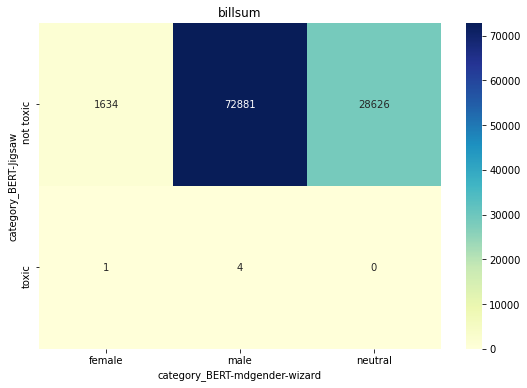

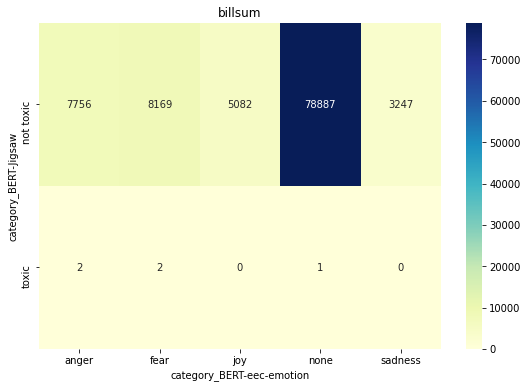

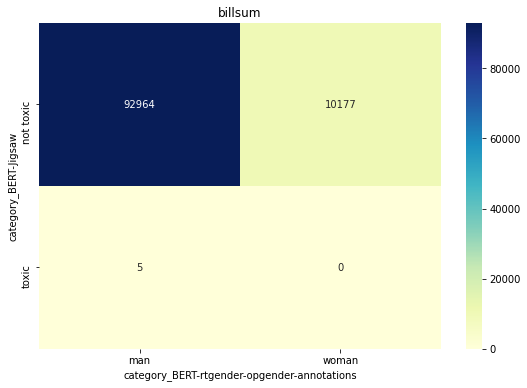

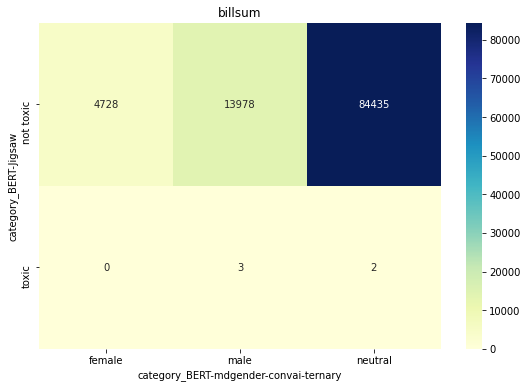

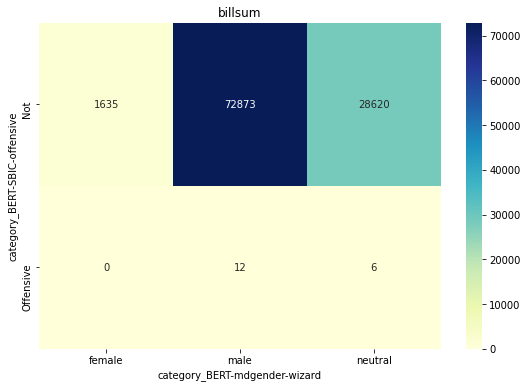

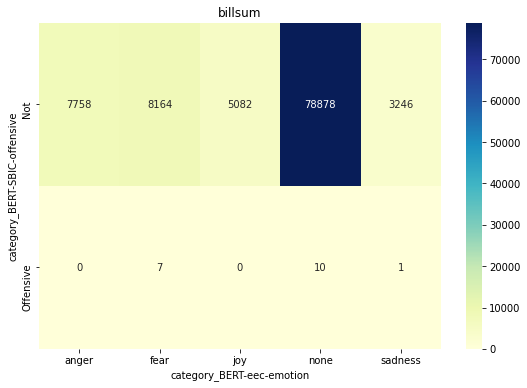

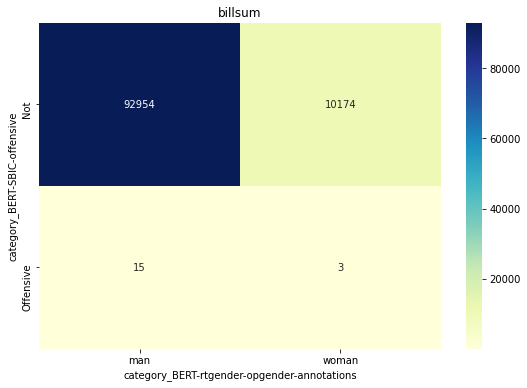

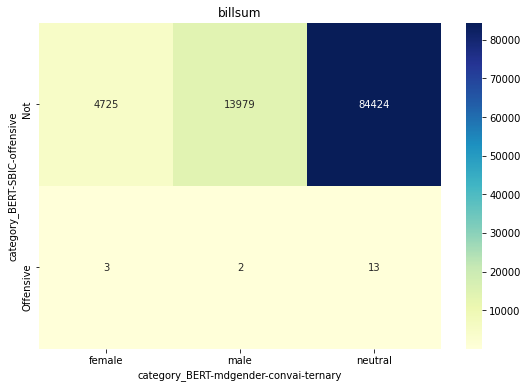

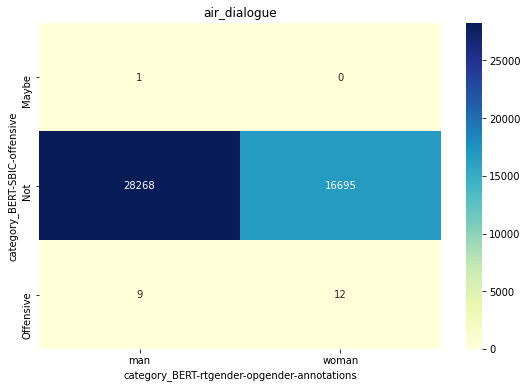

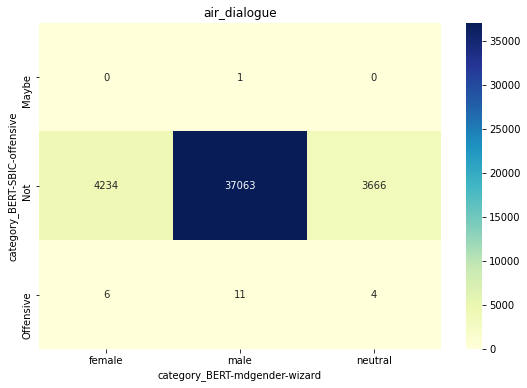

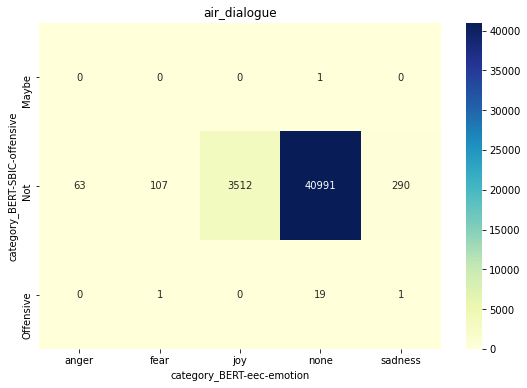

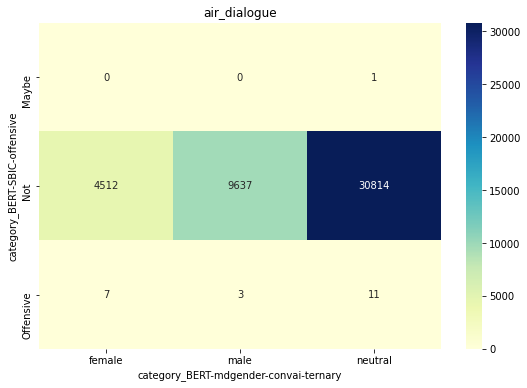

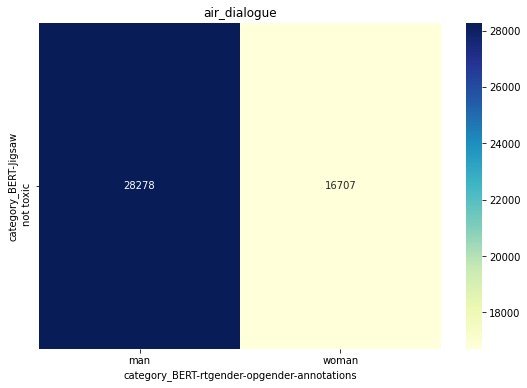

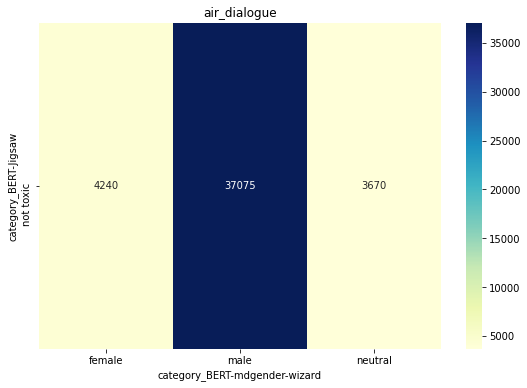

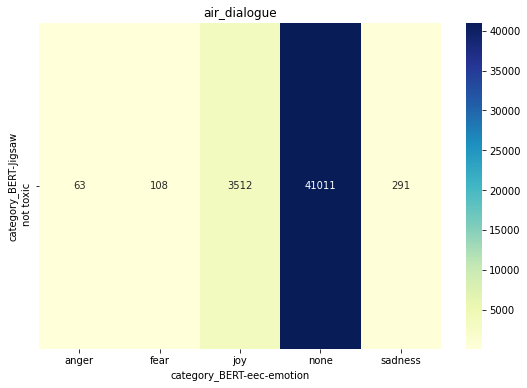

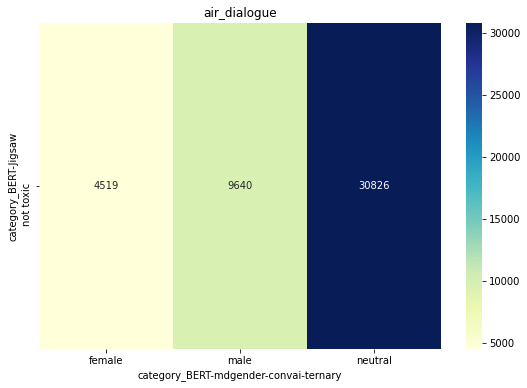

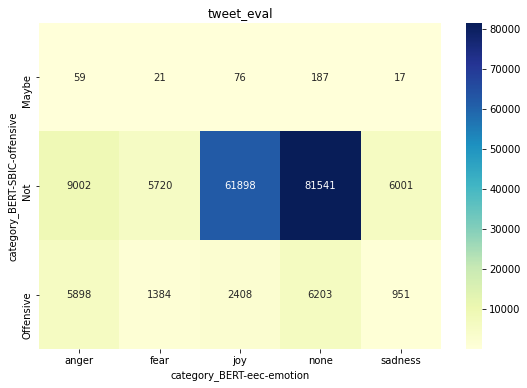

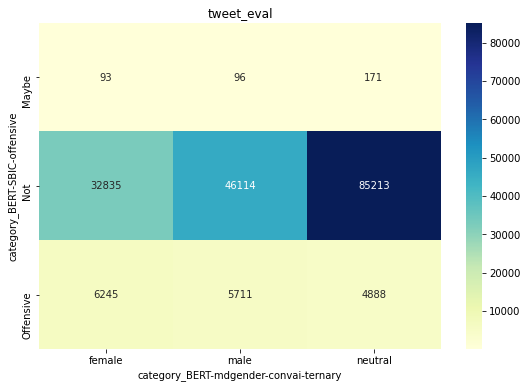

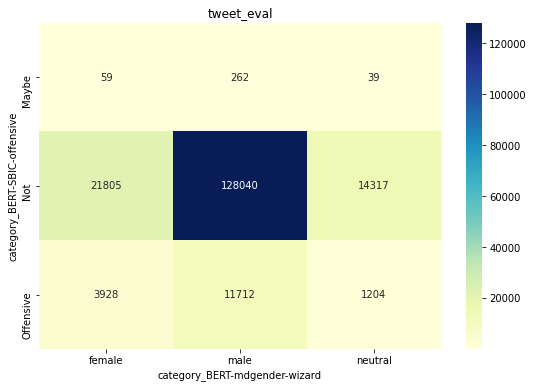

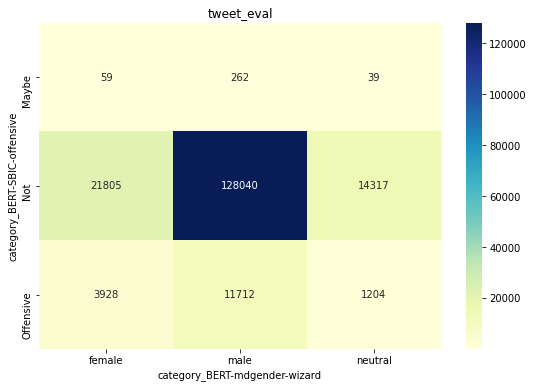

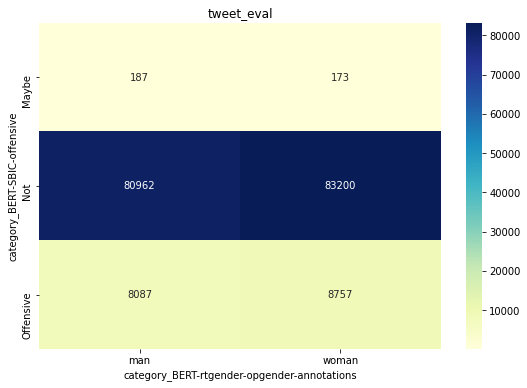

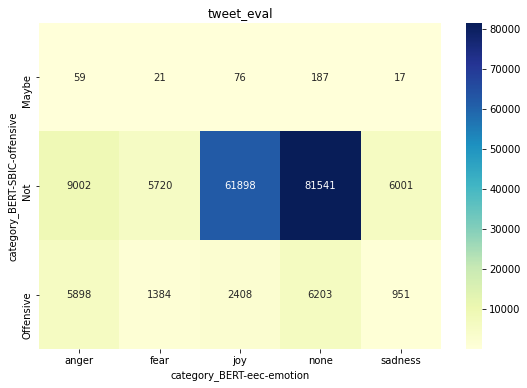

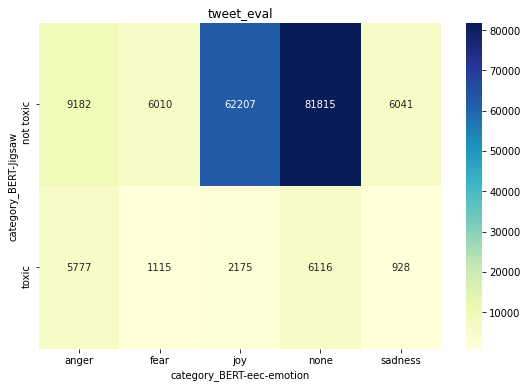

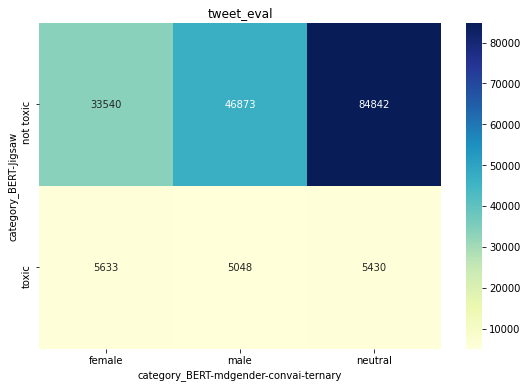

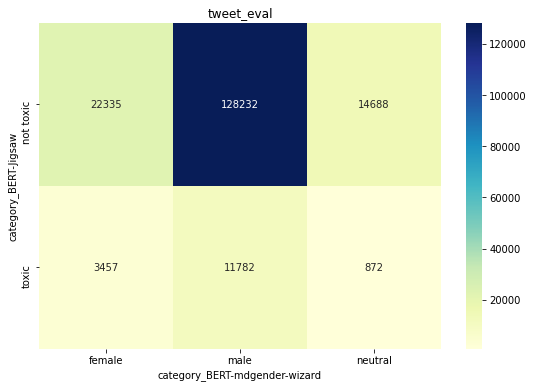

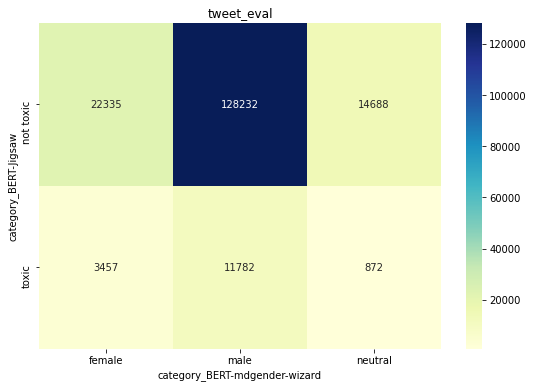

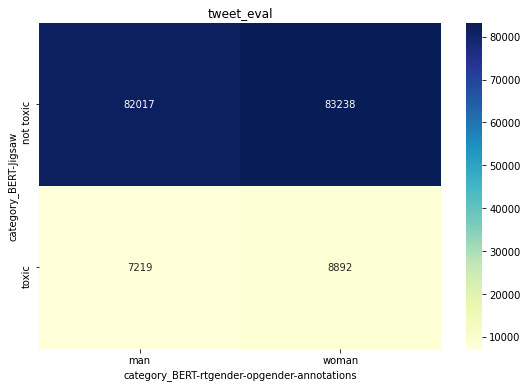

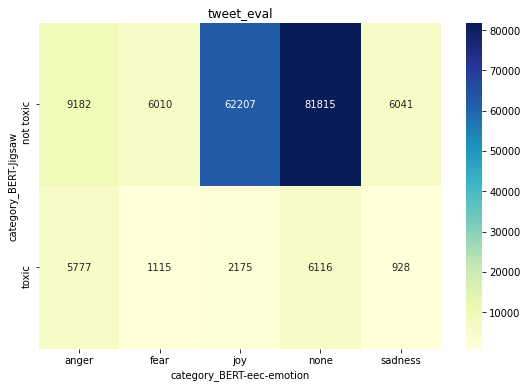

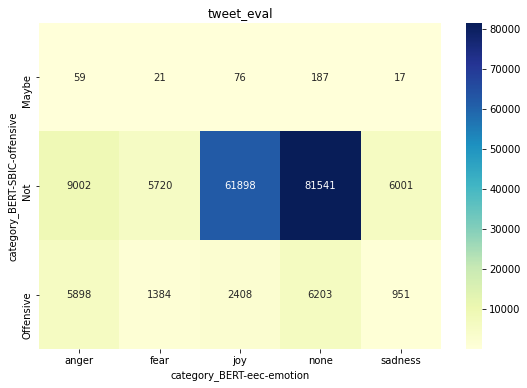

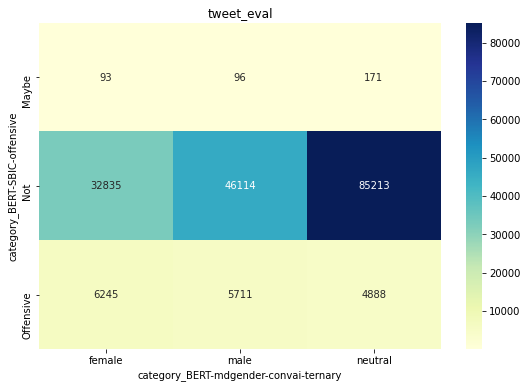

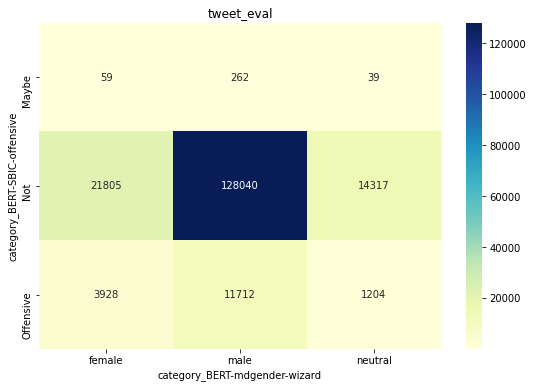

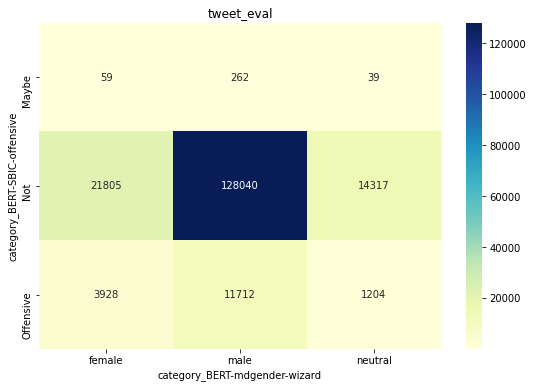

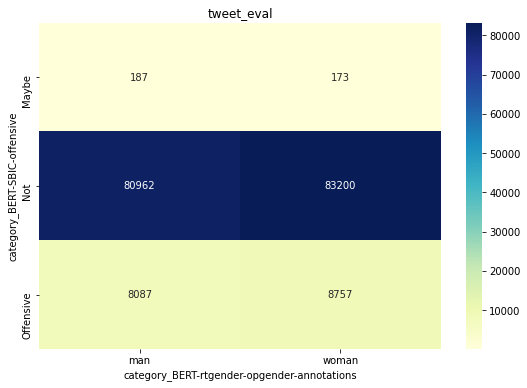

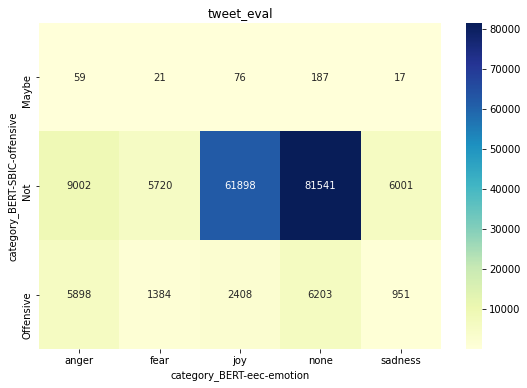

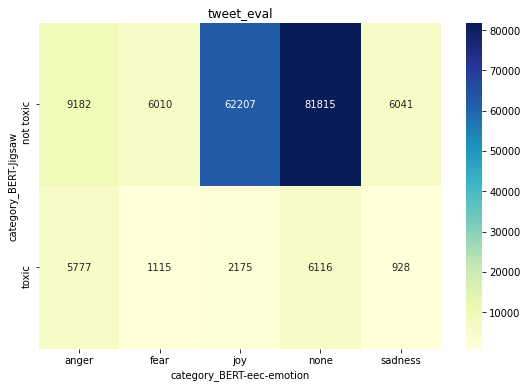

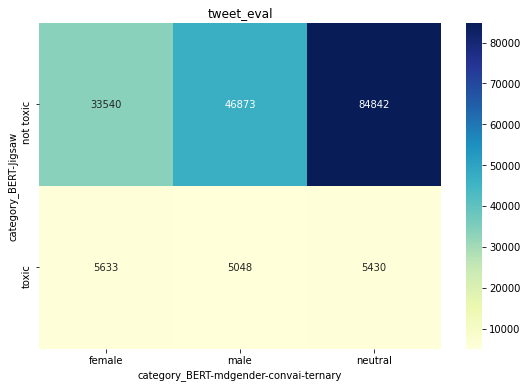

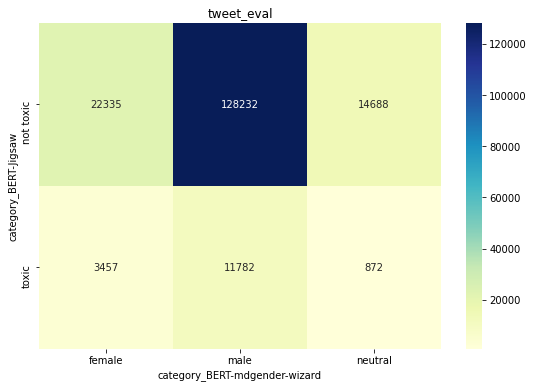

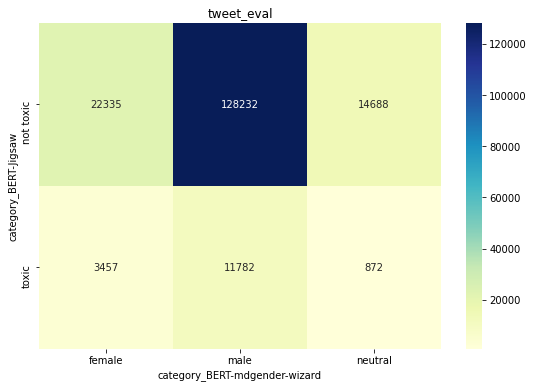

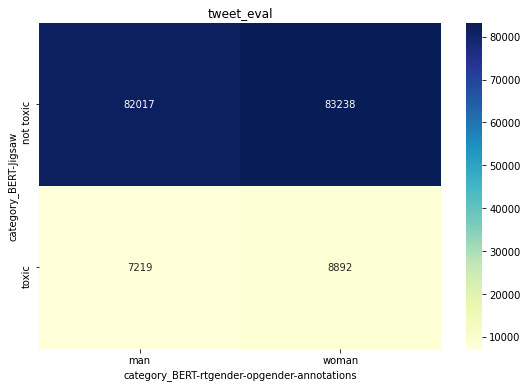

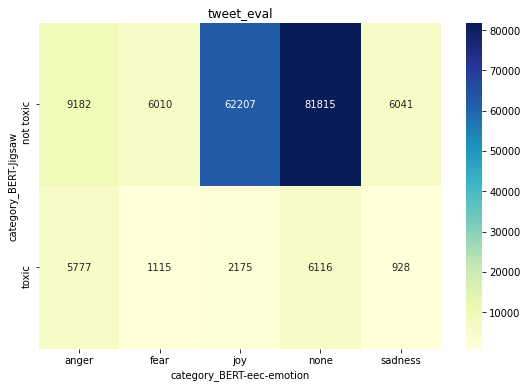

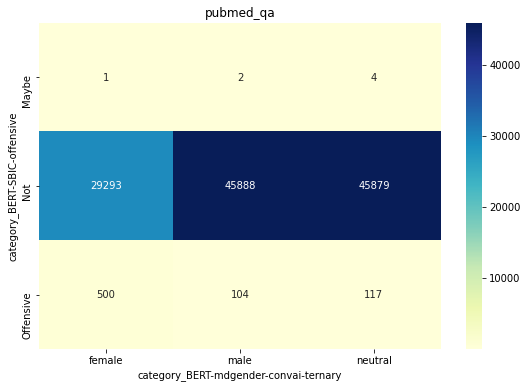

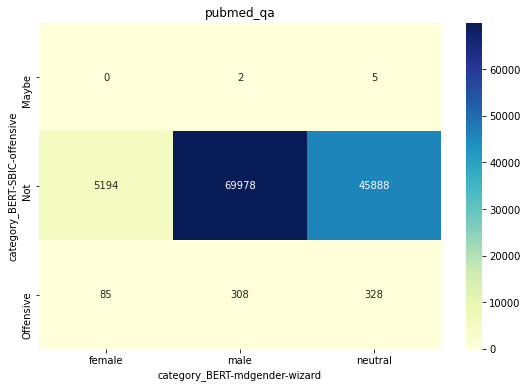

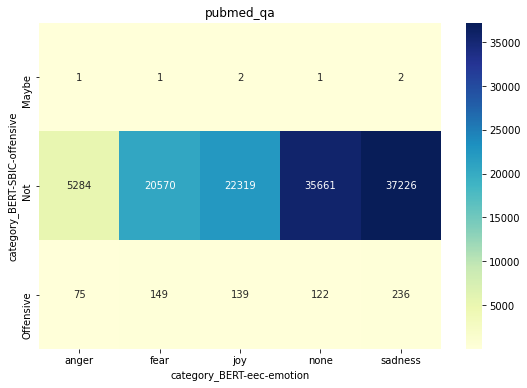

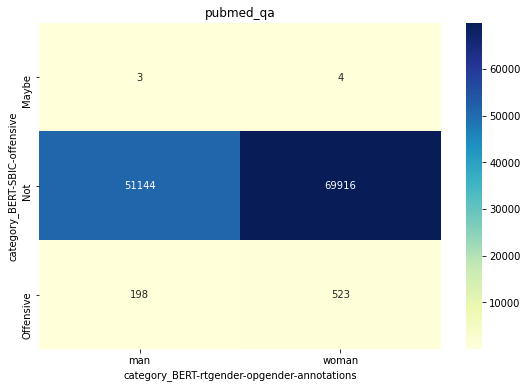

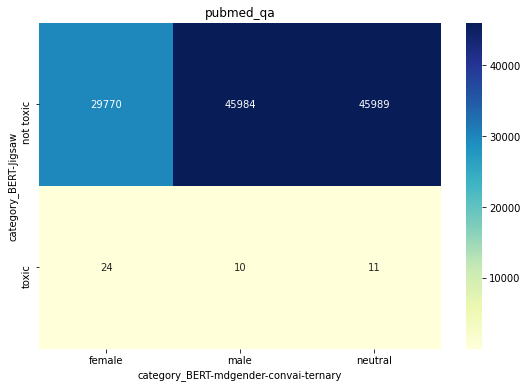

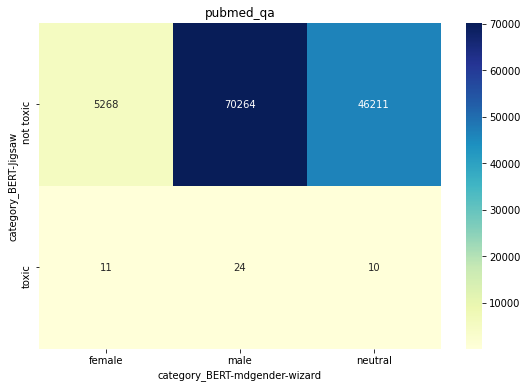

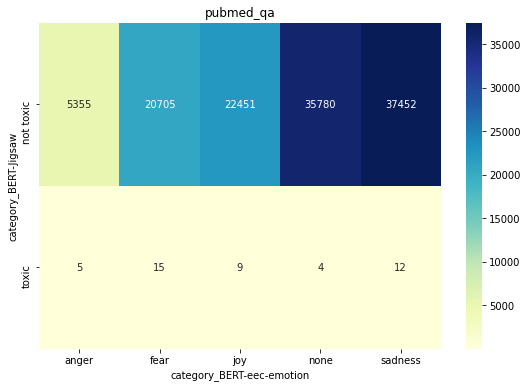

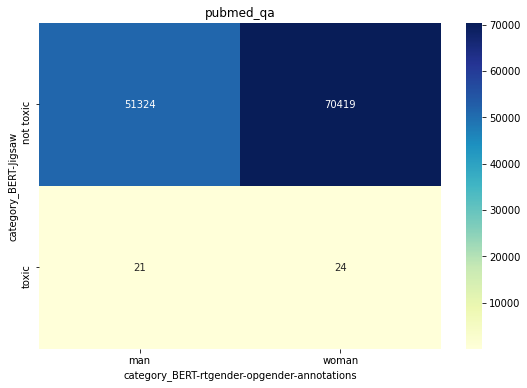

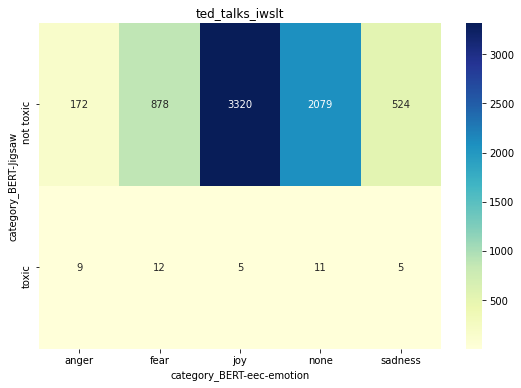

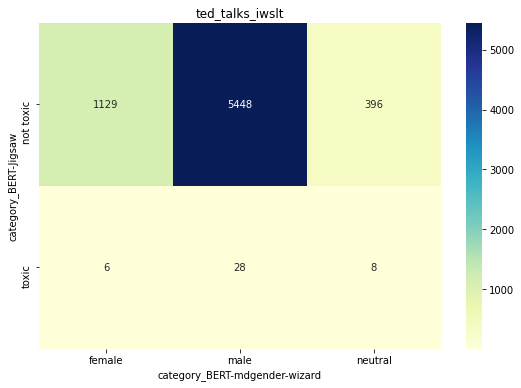

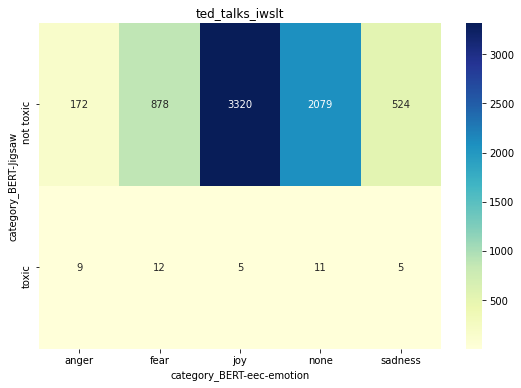

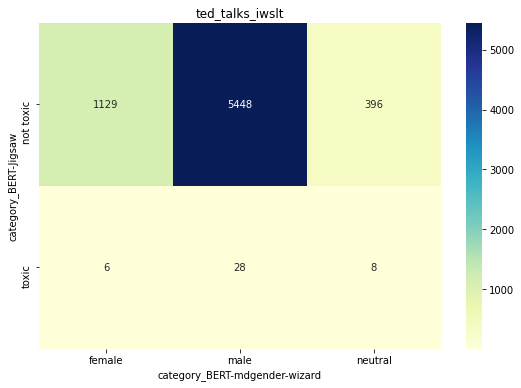

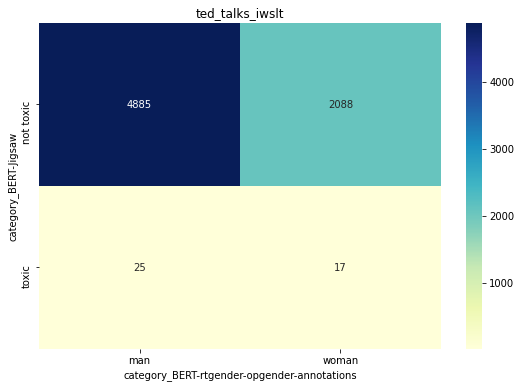

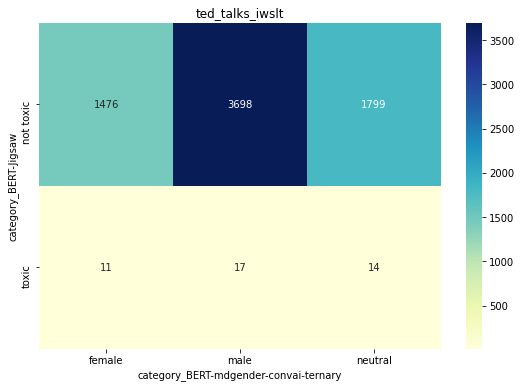

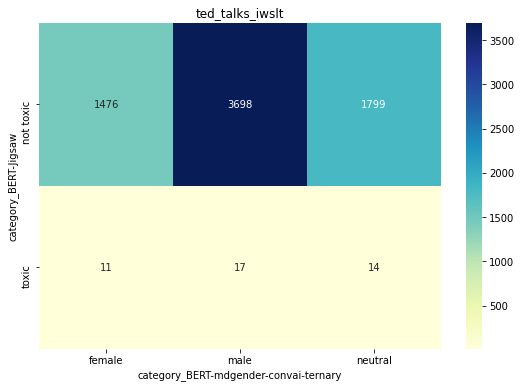

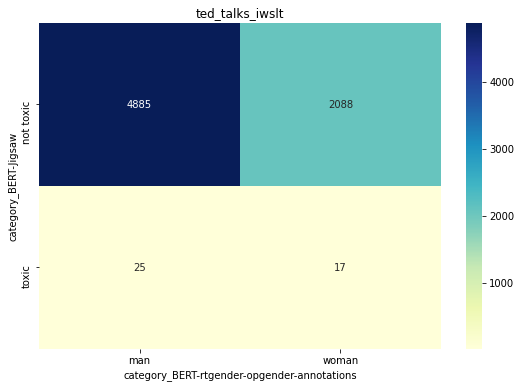

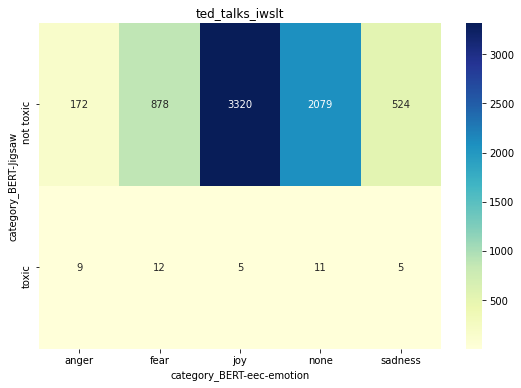

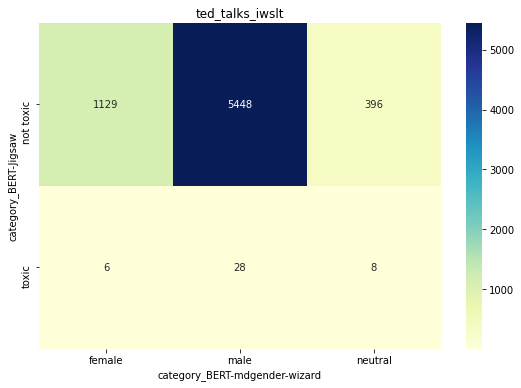

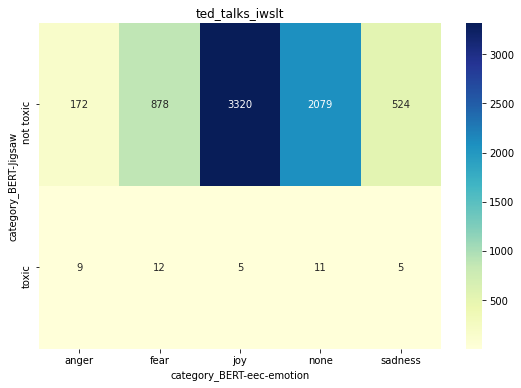

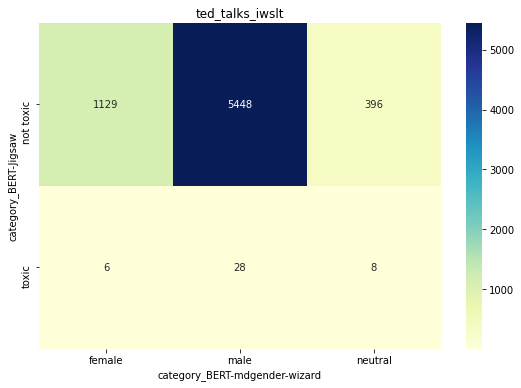

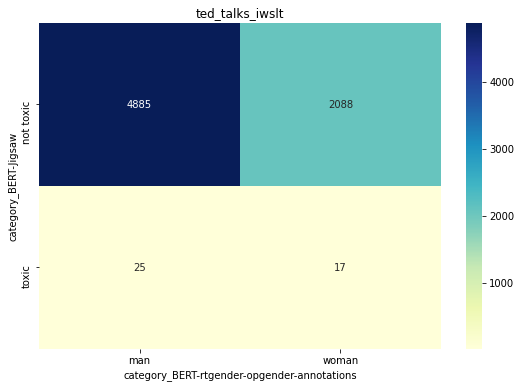

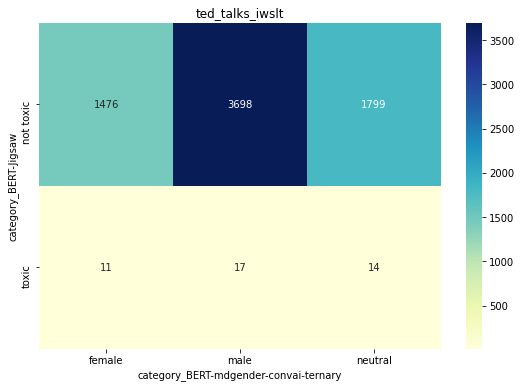

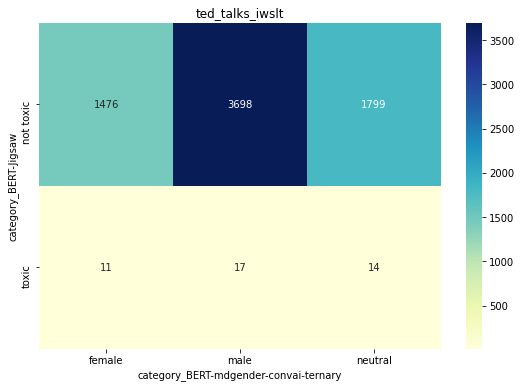

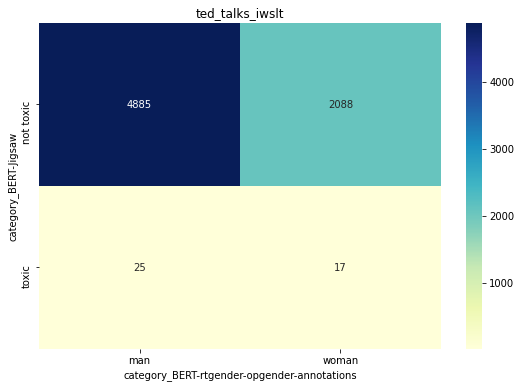

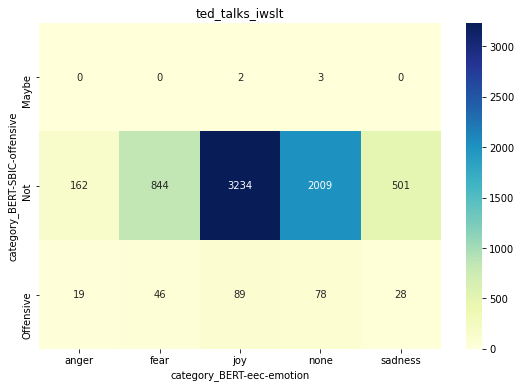

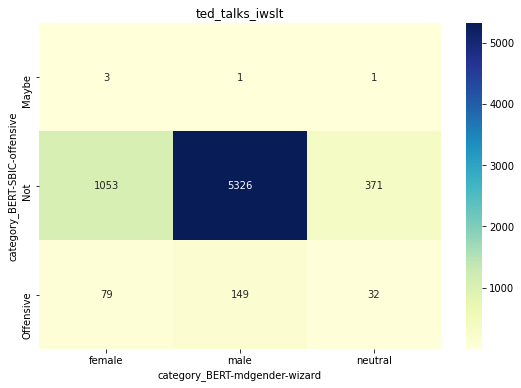

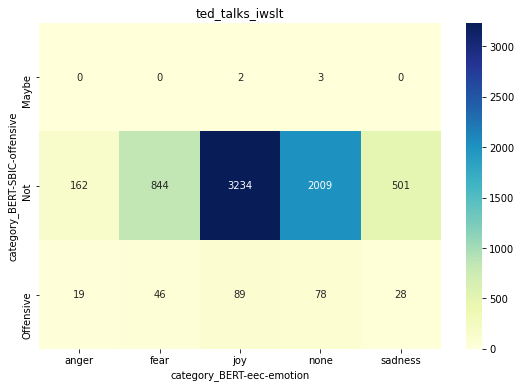

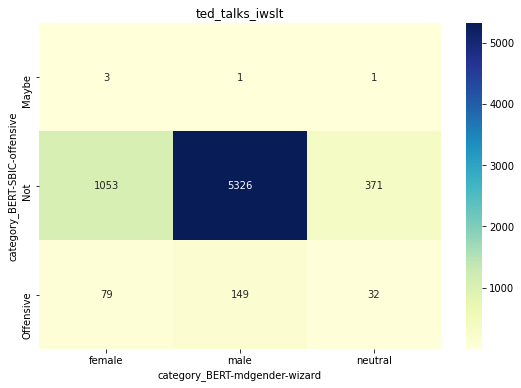

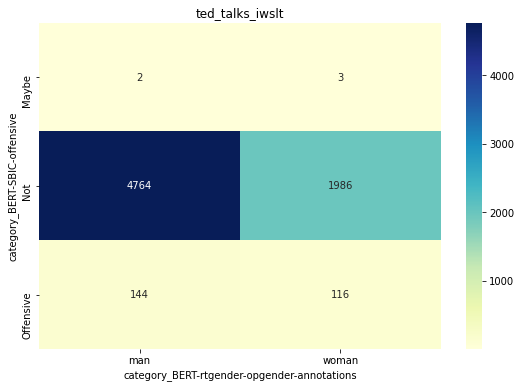

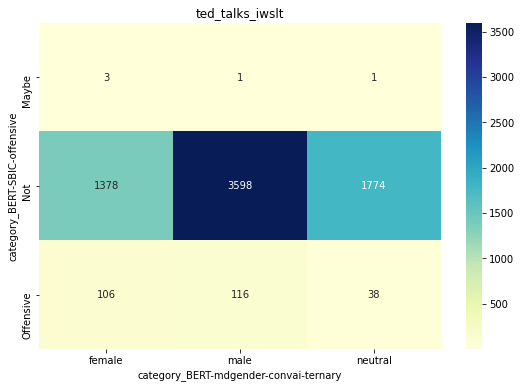

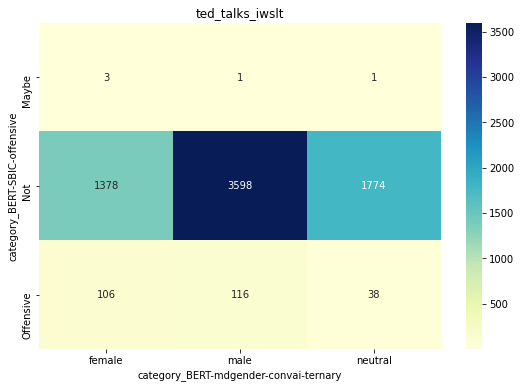

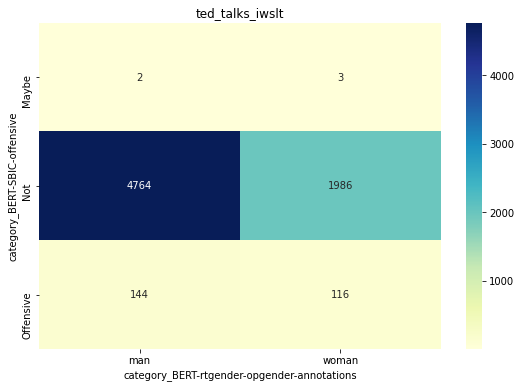

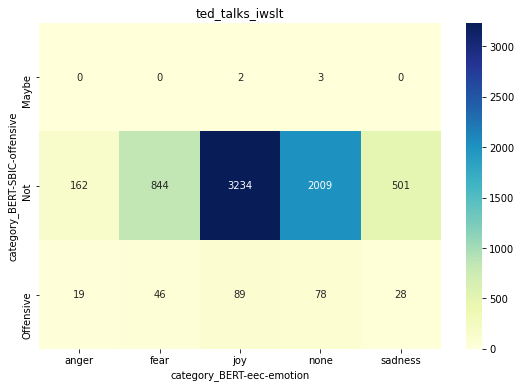

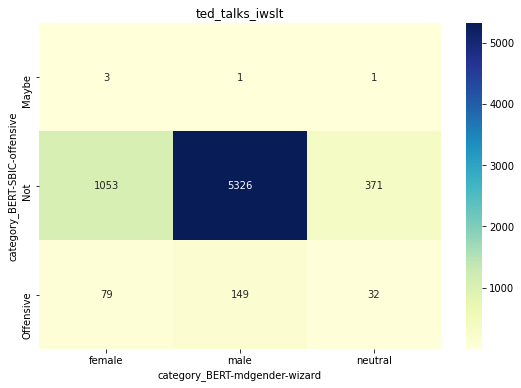

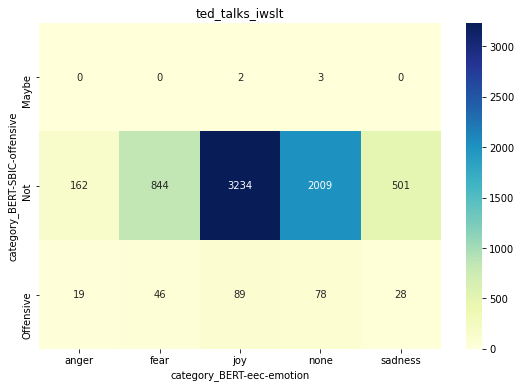

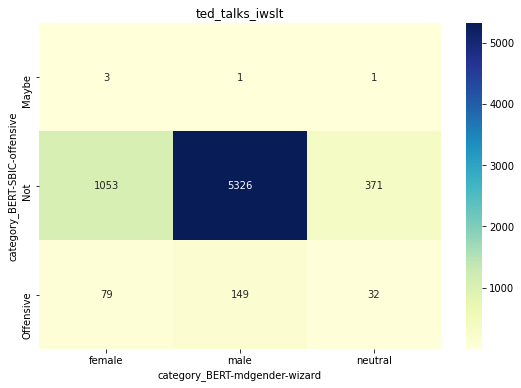

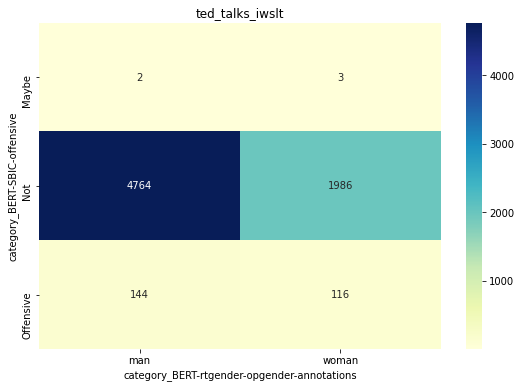

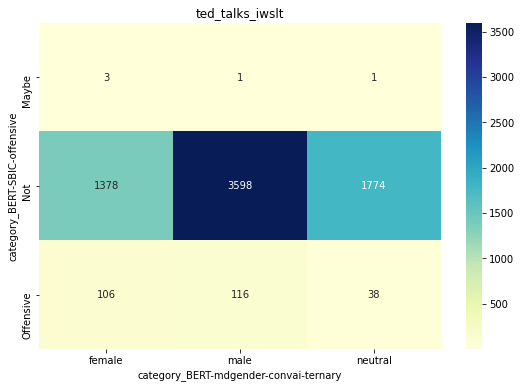

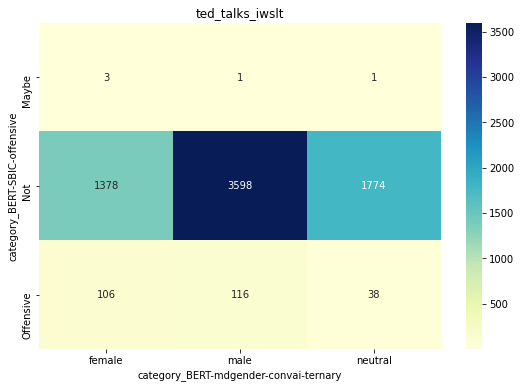

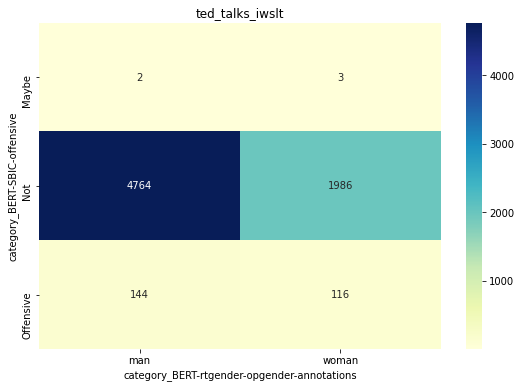

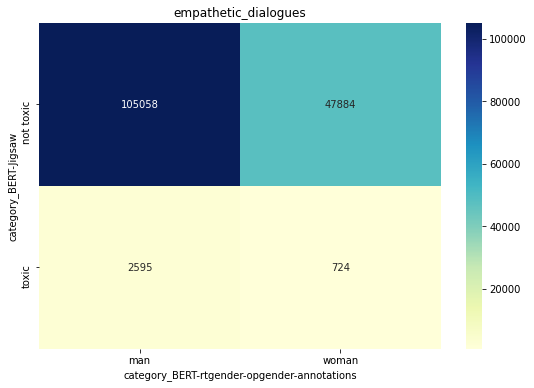

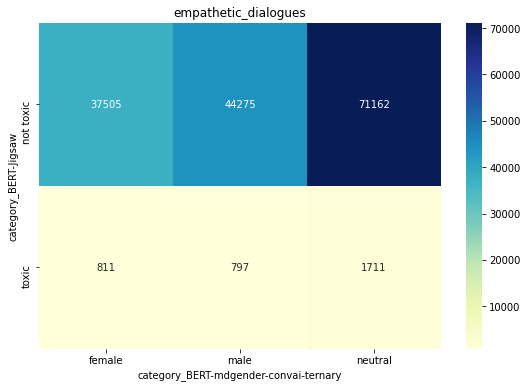

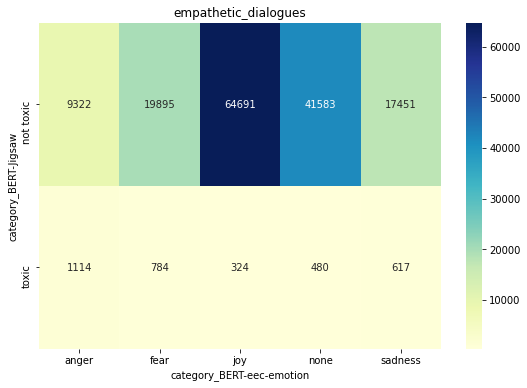

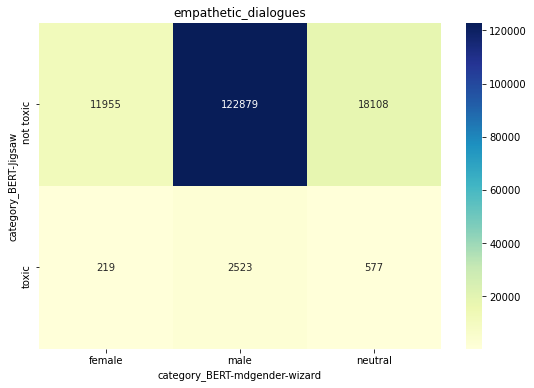

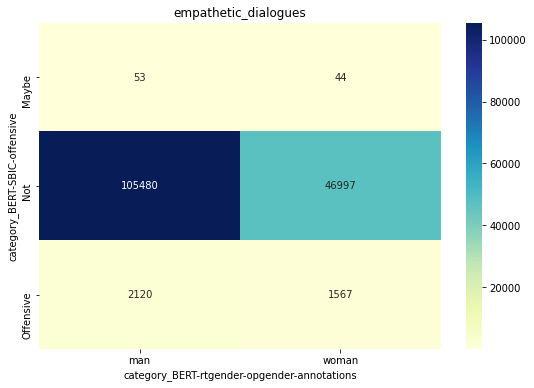

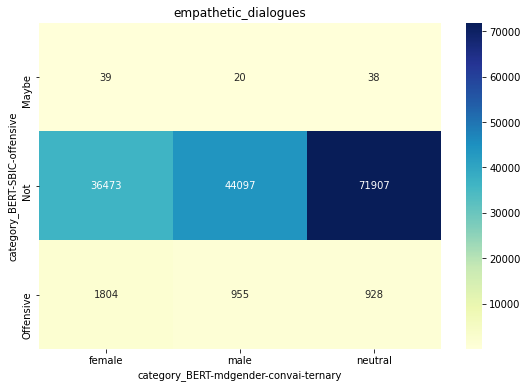

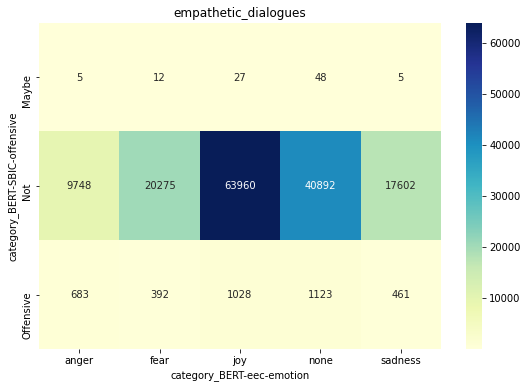

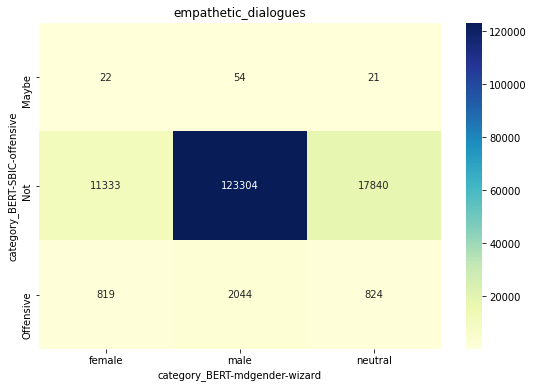

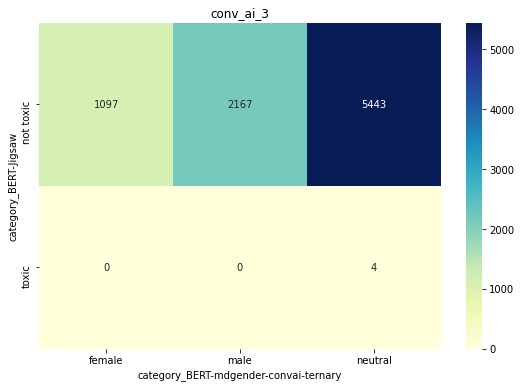

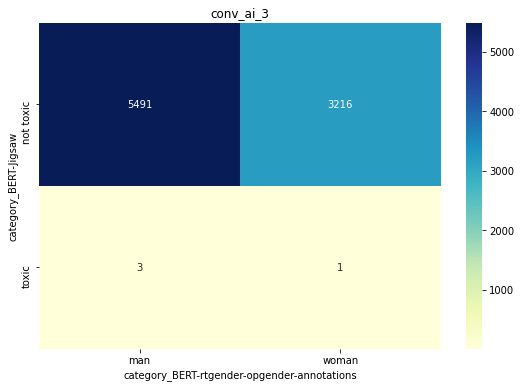

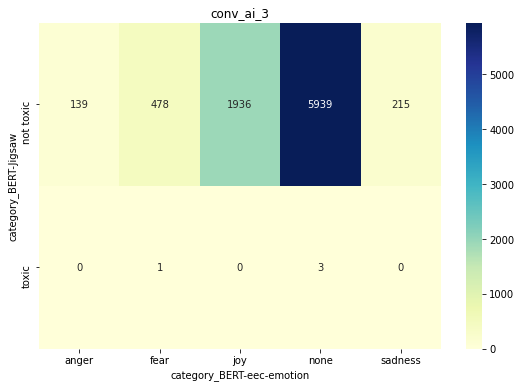

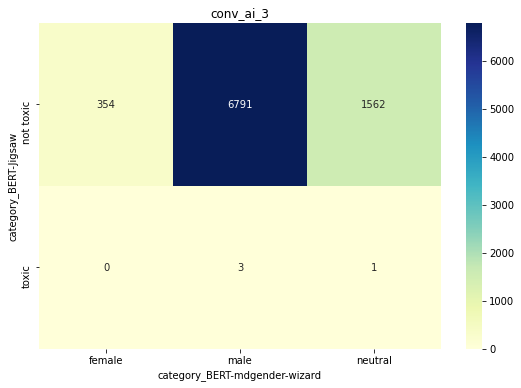

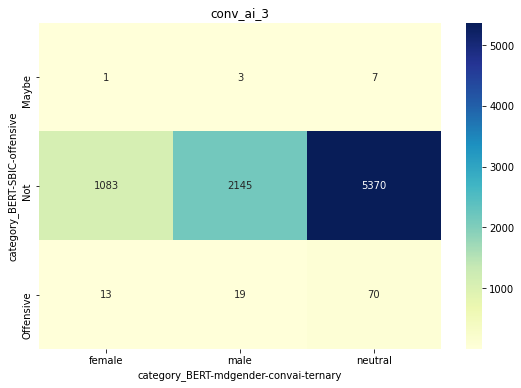

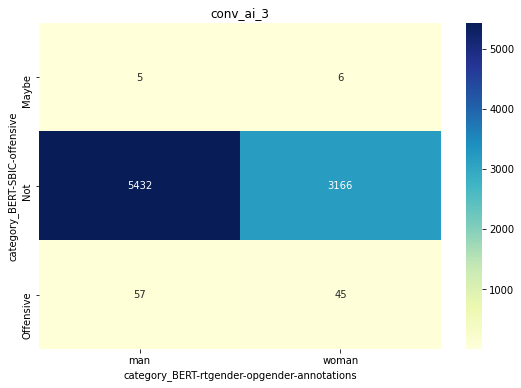

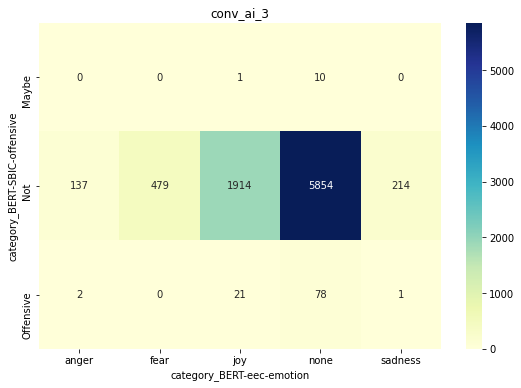

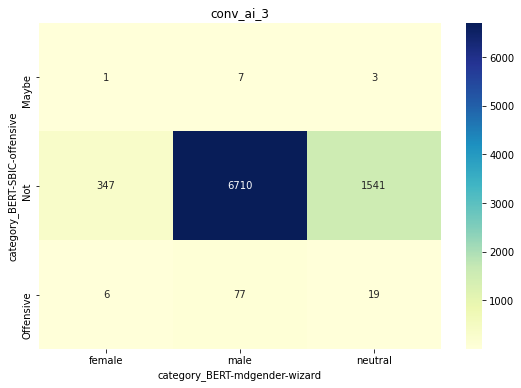

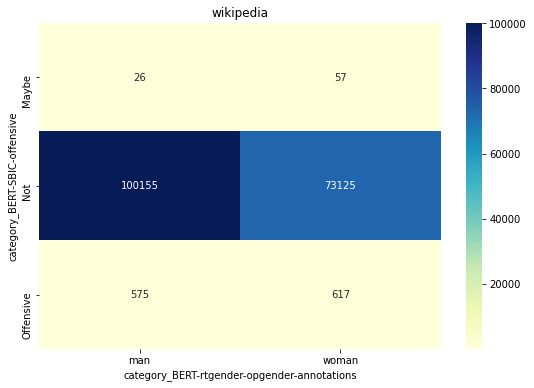

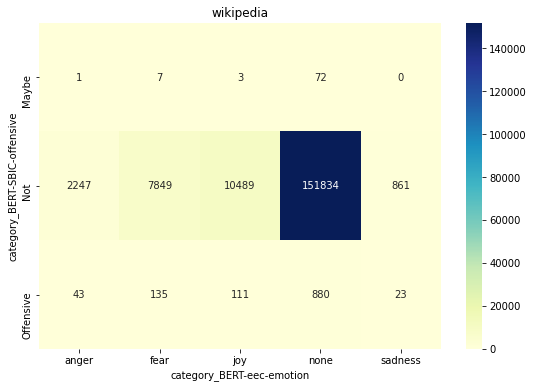

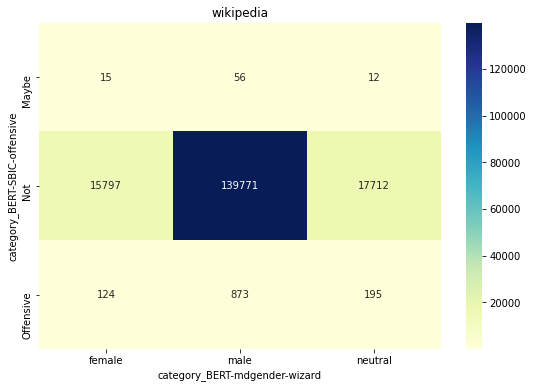

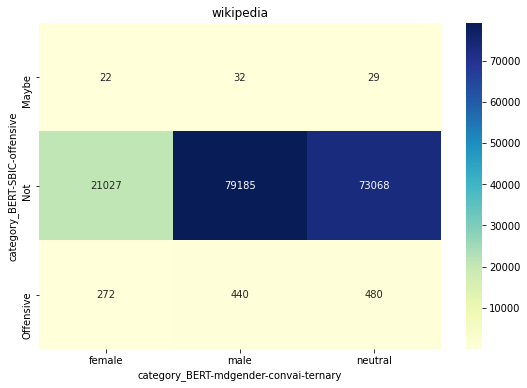

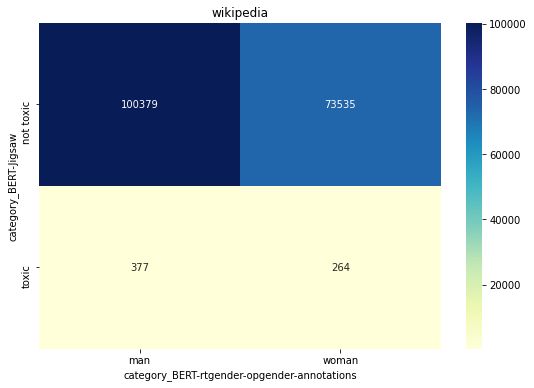

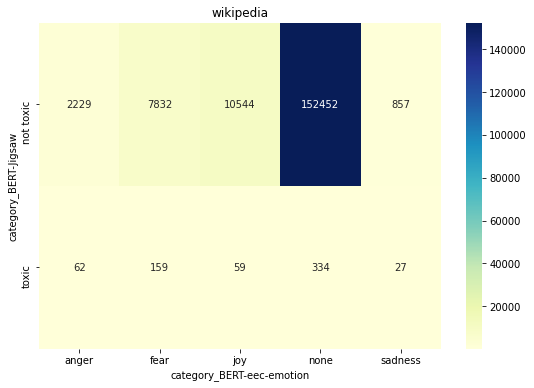

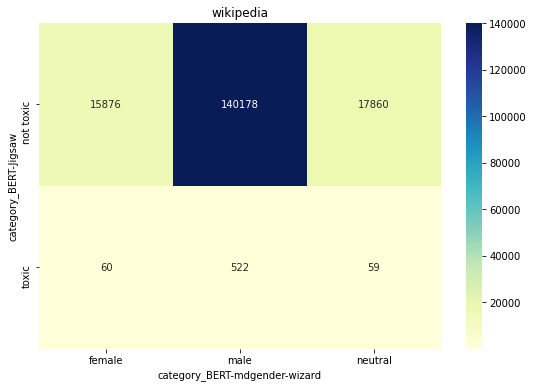

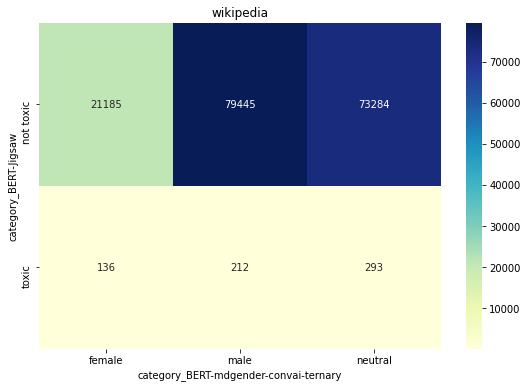

In [23]:
c = []
for eval_dataset_name, ct_list in crosstabs: 
    for ct in ct_list:
        contingency = scale_and_generate(ct, eval_dataset_name)
        c.append(contingency)